Airline Delay Prediction
=========================


Background and Motivation
Every year approximately 20% of airline flights are delayed or cancelled, resulting in significant costs to both travelers and airlines. As a frequent traveler, I am always apprehensive about my flight getting delayed and I keep wondering if only I knew what causes the delay and predict all the factors with reasonable confidence, then not only the airlines will have more control over their planning and mitigate all the frustrations caused to the traveler. 

Historically, flight delays cost the airline industry 8 billion dollars a year due to increased spending on crews, fuel and maintenance. (Source: FAA 2010)
Delay cost passengers nearly $17 billion. (Source FAA 2010)


The goal of this project is to use exploratory analysis and to develop machine learning models to predict airline's departure and arrival delays.

This notebook focuses on airline departure delay prediction using flight and weather data. 

*It consists of the following themes:*

**Data Input and Data Exploration**
1. Input historical flight data for analysis
2. Data exploration and data visualization

**Flight Delay Modeling**
3. Use OLS to examine the the features selected
4. Use random forest method to predict flight delayd and evaluate its predicting capabilities
5. Add a one-hot-encoder to see if the model improves
6. Use SVM to predict flight delay and evaluate its predicting capabilities

**Flight Delay Modeling with Additional Data**
7. Use weather data to help with flight delay prediction

In [191]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # module for plotting
import seaborn as sns
import sklearn as sklearn
from sklearn import linear_model, cross_validation, metrics, svm, ensemble
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.cross_validation  import train_test_split, cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import sem
import statsmodels.api as sm
import itertools

#############################
### Matplotlib
import matplotlib.pyplot as plt # module for plotting 
from matplotlib import interactive, font_manager
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])
dark2_cmap=ListedColormap(dark2_colors)

%matplotlib inline

In [192]:
# setting plot parameters
def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 150
    rcParams['axes.color_cycle'] = dark2_colors
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

######################################
# Remove border function
######################################
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The Data
----------

The data for this project comes from several sources:

* The 2007 and 2008 departure and arrival data is from the American Statistical Association
    * http://stat-computing.org/dataexpo/2009/the-data.html
    
* Historical weather and flight demand data for 2008 is from the FAA Aviation Systems Performance Metrics (ASPM) (https://aspm.faa.gov/)
    * Data was downloaded in two files (one for the 1st half of 2008 and the other for the 2nd half of 2008) 


Data Input and Exploration
-----------------

The first attempt to examine the predictability of flight departure delay is to use historical flight data.

From the website, there are several datasets for years from 1987 to 2008, containing flight arrival and departure records througout the USA. Since the datasets for each year are quite large, we chose to restrict our focus to one year 2008, which already contains close to 1 million records for the largest airports. 

We have taken 2008 as base data for training set and a test set in splits of 1:1. Processing speed being a major consideration since the Machine Learning procedures that work well on smaller datasets cause problems with the Anaconda installations on our computers.

A detailed description of the data elements included is listed in the following table.

Name			Description

Year			1987-2008
Month			12-Jan
DayofMonth		31-Jan
DayOfWeek		1 (Monday) - 7 (Sunday)
DepTime			actual departure time (local, hhmm)
CRSDepTime		scheduled departure time (local, hhmm)
ArrTime			actual arrival time (local, hhmm)
CRSArrTime		scheduled arrival time (local, hhmm)
UniqueCarrier	unique carrier code
FlightNum		flight number
TailNum			plane tail number
ActualElapTime	in minutes
CRSElapsedTime	in minutes
AirTime			in minutes
ArrDelay		arrival delay, in minutes
DepDelay		departure delay, in minutes
Origin			origin IATA airport code
Dest			destination IATA airport code
Distance		in miles
TaxiIn			taxi in time, in minutes
TaxiOut			taxi out time in minutes
Cancelled		was the flight cancelled?
CancellCode		reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
Diverted		1 = yes, 0 = no
CarrierDelay	in minutes
WeatherDelay	in minutes
NASDelay		in minutes
SecurityDelay	in minutes
LateAircraftDel	in minutes

The 2008 on-time performance data contains 7 million records. On average, the daily flights is 19,178 flights. 24 data elements are included in the 2008 flight database. 

In [204]:
# Reading data into flt2008 object

flt2008=pd.read_csv('data/2008.csv')

In [205]:
flt2008.shape

(7009728, 29)

In [206]:
flt2008.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], dtype='object')

We check the structure of the dataset and see that there are several columns that correspond to 'Delays' and also 'Cancelled' flights. We would eventually want to exclude these, since cancelled flights have no delay attributes and restricting the analysis to delayed flights means that we would miss non-delayed flights.

In [207]:
flt2008 = flt2008[flt2008['Cancelled']==0]
flt2008.drop(['Cancelled', 'CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)

In [208]:
flt2008.shape

(6872294, 22)

We need to generate departure and arrival hour attributes from the departure time variables, in order to look at the time of day effect on delays.

In [209]:
#Create new variables
# Hour of CRS Departure Time
flt2008['DepHr'] = flt2008['CRSDepTime']//100
# Hour of CRS Arrival Time
flt2008['ArrHr'] = flt2008['CRSArrTime']//100

Data Exploration
------------

As a first exploaratory analysis, we consider the observed probability of delay in minutes on the entire dataset. The most effective way is through a histogram, looking at departure and arrival delays separately.

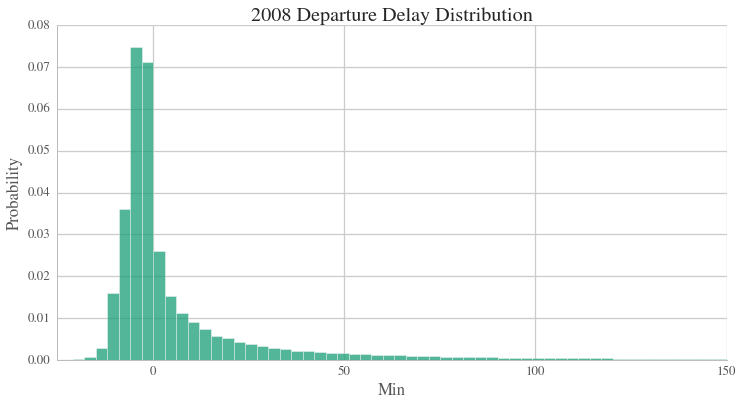

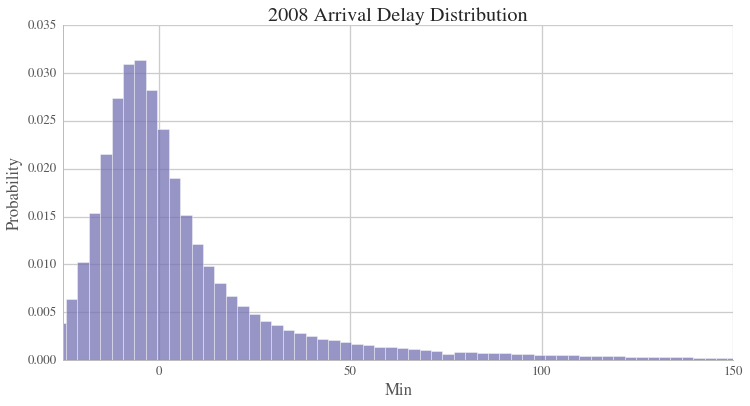

In [101]:
# plt arrival delay distribution
plt.figure(figsize=(12, 6))
plt.hist(flt2008.DepDelay.dropna(),bins = 1000,normed=1, alpha=0.75, color=dark2_colors[0])
plt.xlim(-25,150)
plt.xlabel('Min')
plt.ylabel('Probability')
plt.title('2008 Departure Delay Distribution')
remove_border()

# plt arrival delay distribution
plt.figure(figsize=(12, 6))
plt.hist(flt2008.ArrDelay.dropna(),bins = 1000,normed=1, alpha=0.75, color=dark2_colors[2])
plt.xlim(-25,150)
plt.xlabel('Min')
plt.ylabel('Probability')
plt.title('2008 Arrival Delay Distribution')
remove_border()


We notice a much higher probability of short delays - actually negative, so advances - for departure delays and a wider distrbution (in minutes) for arrivals. Notice the long right-hand tails. Some flights are delayed for very long times, over two hours. On the other hand, the delays are centered around just below zero. In both cases, the mode of the distribution is less than zero, meaning most of the flights leave from gate and arrive at gate even before the published schedule time of departure and arrival. As we will show below, the longer delays cancel out the shorter negative delays (advances), leading to average delays that are above zero.

The x-axis for the two plots are to scale. As a result, we can see that the arrival delay distribution, compared with the deparutre delay distrubiton, leans toward left. A flight delay is defined by the schedule time of an event compared against the actual time of the event. Airlines usually put extra buffer time in a flight to ensure on-time arrival. Therefore, the departure delay and arrival delay distributions difference indicates that some departure delays are recovered during the flights due to the extra amount of time embedded in the flight time between two airports.

Next, we consider the impact of month on the delays. We would expect that winter months have the longest delay. A column chart with departure and arrival delay in minutes plotted by month is the most effective way to see the potential effects of month.

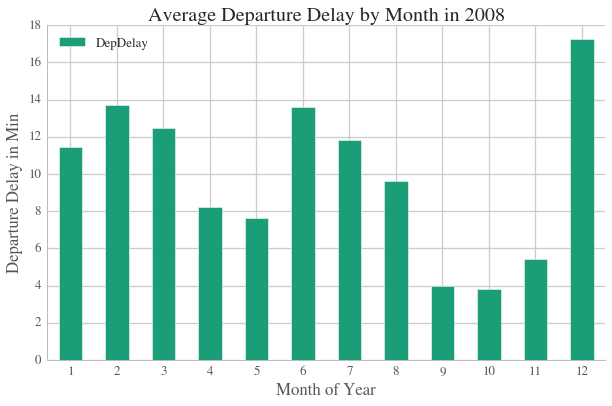

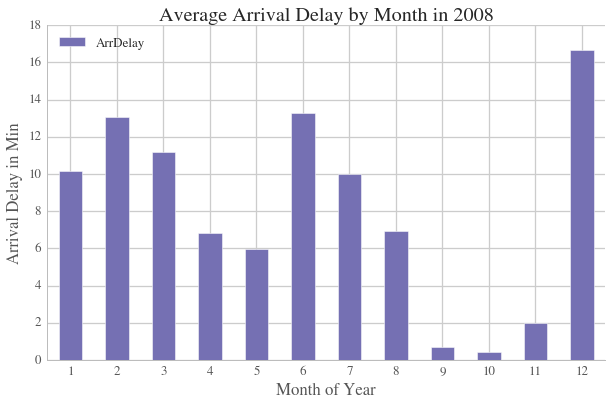

In [102]:
# Look at Month of Year Delay Impact
plt.figure(figsize=(12, 6))
flt2008[['Month','DepDelay']].groupby('Month').mean().plot(kind='bar', color=dark2_colors[0])
plt.xticks(rotation=0)
plt.xlabel('Month of Year')
plt.ylabel('Departure Delay in Min')
plt.title('Average Departure Delay by Month in 2008')
remove_border()

flt2008[['Month','ArrDelay']].groupby('Month').mean().plot(kind='bar', color=dark2_colors[2])
plt.xticks(rotation=0)
plt.xlabel('Month of Year')
plt.ylabel('Arrival Delay in Min')
plt.title('Average Arrival Delay by Month in 2008')
remove_border()


For both departures and arrivals, the impact of December is clear - the highest delays are in that month. On the other hand, September, October and November are the months with the least amount of delay. For the summer, June and July are marked by higher delays. Also,February posts high delay values as well. The reason for winter's high delay values is probably because of snowstorms in the northeast of the US. Also, in summer, thunderstorms in Dallas Forth Worth (DFW) and Chicago areas can cause high delay impact to the rest of country. A snowstorm/storm may only affect operations at an airport or two. However, delay propagation, which marks as the major contributor for flight delay, can cause ripple effects on delay to downstream flight operations. 

We also think that the time of day should have an impact. Normally, flight delays cumulate throughout the day through a knock-on effect, where delayed flights provoke other delays because of tight schedules and runway congestion. We plot the mean delay by hour of day in a column chart. 

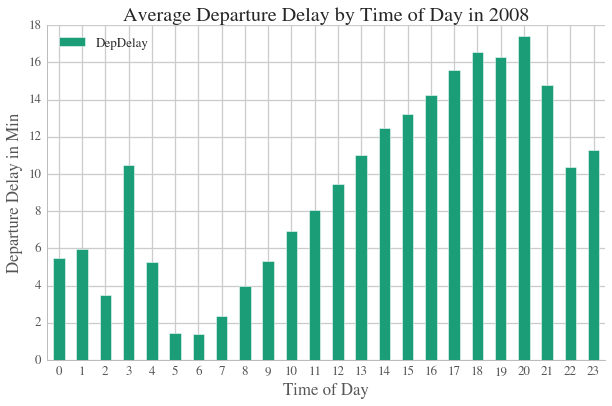

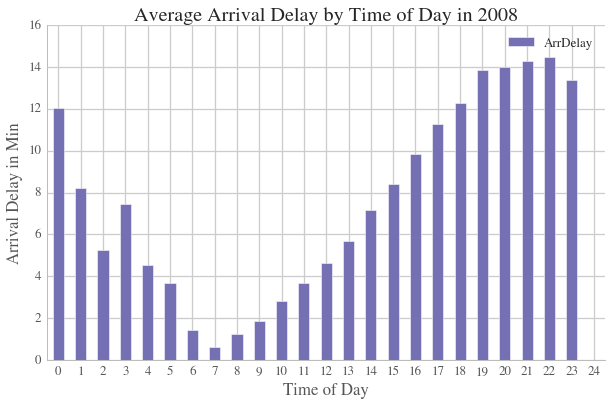

In [103]:
# examine the correlation between departure delay and arrival delay by time of day"
plt.figure(figsize=(12,6))   
flt2008[['DepHr','DepDelay']].groupby('DepHr').mean().plot(kind='bar', color=dark2_colors[0])
plt.xticks(rotation=0)
plt.xlabel('Time of Day')
plt.ylabel('Departure Delay in Min')
plt.title('Average Departure Delay by Time of Day in 2008')
remove_border()

flt2008[['ArrHr','ArrDelay']].groupby('ArrHr').mean().plot(kind='bar', color=dark2_colors[2])
plt.xticks(rotation=0)
plt.xlabel('Time of Day')
plt.ylabel('Arrival Delay in Min')
plt.title('Average Arrival Delay by Time of Day in 2008')
remove_border()


We see a marked "V" shaped decline in delay with the lowest delays in early morning hours. Both departure and arrival delays accumulate from earlier morning reaching their peaks in the evening hours. For departure, the highest mean delay is during prime-time of 18:00 to 21:00, and for arrivals, it is slightly later (the average flight duration is a few hours) and peaks at around 22:00. The increasing of flight delay by the hours of the day is mainly caused by flight delay propagation. Although a flight is built with scheduled buffer time for unforeseeable flight delay during the flight operations, it is not sufficient to cover all types of delay. As a result, if a flight is delayed, the next flight has to wait for the late arrival flight to be ready before it can be operated. Hence, flight delays for both departure and arrival flights do increase over time. 

The variation in mean delay by hour that we see implies that Hour of Day should be a good predictor of flight delay.

**Creating JSON files with mean delays by date and airport**

For the purposes of visualizing the mean delays on a map for the website, we create a pivot table and then save the results in a JSON file, by date and airport code. We are interested in the mean delay on any particular day and month, and also the mean delay according to the hour of day.

In [104]:
DepDelayByDepHr = flt2008.pivot_table(values='DepDelay', index=['Month', 'DayofMonth', 'Origin'],#, 'Dest'], 
                                   columns='DepHr', aggfunc=np.mean, dropna=True)
DepDelayByArrHr = flt2008.pivot_table(values='DepDelay', index=['Month', 'DayofMonth', 'Origin'],#, 'Dest'], 
                                   columns='ArrHr', aggfunc=np.mean, dropna=True)
ArrDelayByDepHr = flt2008.pivot_table(values='ArrDelay', index=['Month', 'DayofMonth', 'Origin'],#, 'Dest'], 
                                   columns='DepHr', aggfunc=np.mean, dropna=True)
ArrDelayByArrHr = flt2008.pivot_table(values='ArrDelay', index=['Month', 'DayofMonth', 'Origin'],#, 'Dest'], 
                                   columns='ArrHr', aggfunc=np.mean, dropna=True)

In [105]:
DepDelayTotal = flt2008.pivot_table(values='DepDelay', index=['Month', 'DayofMonth'],#, 'Origin'], 
                                   columns='Origin', aggfunc=np.mean, dropna=True)
ArrDelayTotal = flt2008.pivot_table(values='ArrDelay', index=['Month', 'DayofMonth'],#, 'Origin'], 
                                   columns='Origin', aggfunc=np.mean, dropna=True)


In [106]:
# Create the JSON files with the data from the Pivot Tables
DepDelayByDepHr.to_json('data/DepDelayByDepHr.json', orient='index')
DepDelayByArrHr.to_json('data/DepDelayByArrHr.json', orient='index')
ArrDelayByDepHr.to_json('data/ArrDelayByDepHr.json', orient='index')
ArrDelayByArrHr.to_json('data/ArrDelayByArrHr.json', orient='index')

In [107]:
DepDelayTotal.to_json('data/DepDelayTotal.json', orient='index')
ArrDelayTotal.to_json('data/ArrDelayTotal.json', orient='index')

In [108]:
del DepDelayByDepHr, DepDelayByArrHr, ArrDelayByDepHr, ArrDelayByArrHr
del DepDelayTotal, ArrDelayTotal

*** Comparison of mean delays across 4 different airports ***

For the next step, we will pick four major airports and compare these distributions across these airports to see whether the impacts of month and hour of day are similar at different airports. This analysis could be easiliiy extended to all airports, but for the purposes here, it is sufficient to consider just four.

We subset the dataset into flights departing or arriving at Chicago O'Hare (ORD), Boston Logan (BOS), San Francisco (SFO) and New York LaGuardia(LGA).

In [109]:
# Let us focus on major airports only - ORD, BOS, SFO and LGA
# for 2008
flt2008ORD = flt2008[(flt2008['Origin'] == 'ORD') | (flt2008['Dest']=='ORD')]
flt2008BOS = flt2008[(flt2008['Origin'] == 'BOS') | (flt2008['Dest']=='BOS')]
flt2008SFO = flt2008[(flt2008['Origin'] == 'SFO') | (flt2008['Dest']=='SFO')]
flt2008LGA = flt2008[(flt2008['Origin'] == 'LGA') | (flt2008['Dest']=='LGA')]

In [110]:
flt2008ORD.head().T

,94059,102746,102807,103000,103061
Year,2008,2008,2008,2008,2008
Month,1,1,1,1,1
DayofMonth,8,25,10,4,22
DayOfWeek,2,5,4,5,2
DepTime,1711,1813,1601,658,725
CRSDepTime,1600,1742,1600,650,725
ArrTime,2031,2040,1928,1002,834
CRSArrTime,1945,2004,1945,955,757
UniqueCarrier,XE,XE,XE,XE,XE
FlightNum,1226,2229,1226,1220,2408


C:\Anaconda3\lib\site-packages\seaborn\categorical.py:2885: UserWarning: The `hline` parameter has been removed
  warnings.warn("The `hline` parameter has been removed", UserWarning)


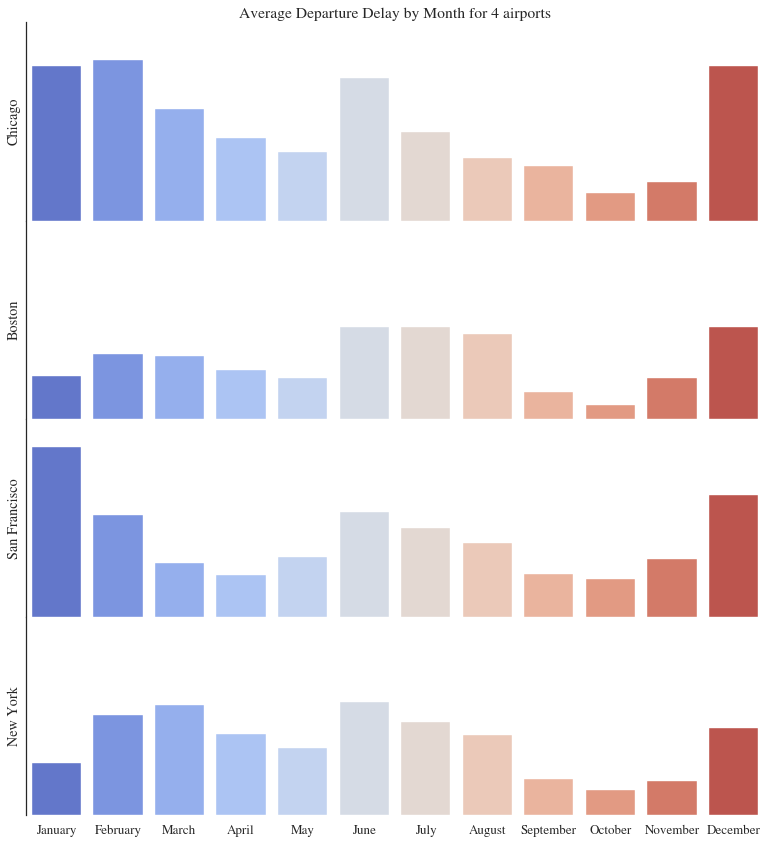

In [111]:
Months = np.array(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
mon = np.arange(len(Months))
sns.set(style="white", font='StixGeneral', context="talk")

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(11, 12), sharex=True, sharey=True)
sns.barplot(mon, flt2008ORD[['Month','DepDelay']].groupby('Month').mean().reset_index().DepDelay, ci=None, palette="coolwarm", hline=0, ax=ax1)

ax1.set_title('Average Departure Delay by Month for 4 airports')
ax1.set_ylabel('Chicago'); ax1.set_xlabel(''); 
sns.barplot(mon, flt2008BOS[['Month','DepDelay']].groupby('Month').mean().reset_index().DepDelay, ci=None, palette="coolwarm", hline=0, ax=ax2)
ax2.set_ylabel('Boston'); ax2.set_xlabel('')
sns.barplot(mon, flt2008SFO[['Month','DepDelay']].groupby('Month').mean().reset_index().DepDelay, ci=None, palette="coolwarm", hline=0, ax=ax3)
ax3.set_ylabel('San Francisco'); ax3.set_xlabel('')
sns.barplot(mon, flt2008LGA[['Month','DepDelay']].groupby('Month').mean().reset_index().DepDelay, ci=None, palette="coolwarm", hline=0, ax=ax4)
ax4.set_ylabel('New York'); ax4.set_xlabel('')
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[], xticklabels=Months)
plt.tight_layout(h_pad=0)


We see differences between airports - Chicago O'Hare and San Francisco are similar to the overall profile for mean delay at all airports, with higher delays in December and January and a midsummer bump. On the other hand, Boston Logan shows lower mean delays in the beginning of the year and more delays in all 3 summer holiday months. New York LaGuardia has more delay in the springtime, with February, March and June with a higher mean delay than in December. In all locations, December is a month with higher than normal delays.

Given that Northeast Corridor do receives significant amount of rain/snow, further analysis is required for examining the cauase and distributions (temporal and spatial relationship) of the flight departure delay.

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:2885: UserWarning: The `hline` parameter has been removed
  warnings.warn("The `hline` parameter has been removed", UserWarning)


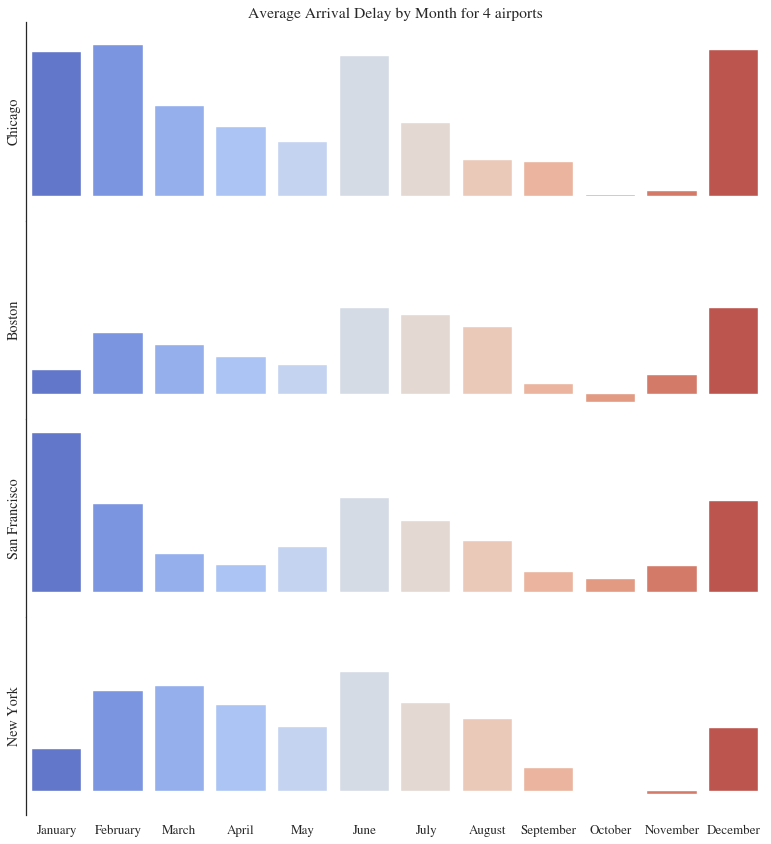

In [112]:
Months = np.array(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
mon = np.arange(len(Months))
sns.set(style="white", font='StixGeneral', context="talk")
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(11, 12), sharex=True, sharey=True)

sns.barplot(mon, flt2008ORD[['Month','ArrDelay']].groupby('Month').mean().reset_index().ArrDelay, ci=None, palette="coolwarm", hline=0, ax=ax1)
ax1.set_title('Average Arrival Delay by Month for 4 airports')
ax1.set_ylabel('Chicago'); ax1.set_xlabel(''); 
sns.barplot(mon, flt2008BOS[['Month','ArrDelay']].groupby('Month').mean().reset_index().ArrDelay, ci=None, palette="coolwarm", hline=0, ax=ax2)
ax2.set_ylabel('Boston'); ax2.set_xlabel('')
sns.barplot(mon, flt2008SFO[['Month','ArrDelay']].groupby('Month').mean().reset_index().ArrDelay, ci=None, palette="coolwarm", hline=0, ax=ax3)
ax3.set_ylabel('San Francisco'); ax3.set_xlabel('')
sns.barplot(mon, flt2008LGA[['Month','ArrDelay']].groupby('Month').mean().reset_index().ArrDelay, ci=None, palette="coolwarm", hline=0, ax=ax4)
ax4.set_ylabel('New York'); ax4.set_xlabel('')
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[], xticklabels=Months)
plt.tight_layout(h_pad=0)

For arrival delays, we see four distinct peak months for Chicago O'Hare. December, January, February and June. The latter may be because of holiday travel. The former three may be entirely weather related since these three months have the worst climatic conditions. San Francisco is similar to Chicago again. The peak delay is in January possibly weather related (bad winter conditions in January 2008). Again the springtime peak in New York shows the longest delays from February to June. In all locations, the end of year only has minimal delays in October and November, with delays rising back up in December.

Next we would like to consider the impact of Hour of Day across the airports. We repeat the analysis for departure and arrival delay by hour.

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:2885: UserWarning: The `hline` parameter has been removed
  warnings.warn("The `hline` parameter has been removed", UserWarning)


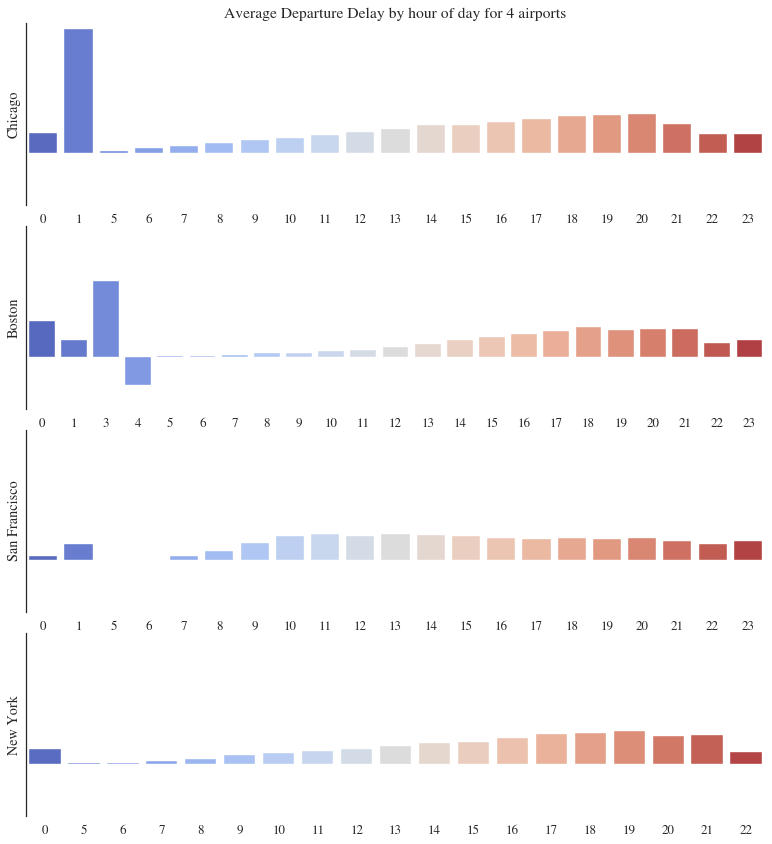

In [113]:
ORD = flt2008ORD[['DepHr','DepDelay']].groupby('DepHr').mean().reset_index()
BOS = flt2008BOS[['DepHr','DepDelay']].groupby('DepHr').mean().reset_index()
SFO = flt2008SFO[['DepHr','DepDelay']].groupby('DepHr').mean().reset_index()
LGA = flt2008LGA[['DepHr','DepDelay']].groupby('DepHr').mean().reset_index()
sns.set(style="white", font='StixGeneral', context="talk")
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(11, 12), sharex=False, sharey=True)

sns.barplot(ORD.DepHr, ORD.DepDelay, ci=None, palette="coolwarm", hline=0, ax=ax1)
ax1.set_title('Average Departure Delay by hour of day for 4 airports')
ax1.set_ylabel('Chicago'); ax1.set_xlabel(''); 
sns.barplot(BOS.DepHr, BOS.DepDelay, ci=None, palette="coolwarm", hline=0, ax=ax2)
ax2.set_ylabel('Boston'); ax2.set_xlabel('')
sns.barplot(SFO.DepHr, SFO.DepDelay, ci=None, palette="coolwarm", hline=0, ax=ax3)
ax3.set_ylabel('San Francisco'); ax3.set_xlabel('')
sns.barplot(LGA.DepHr, LGA.DepDelay, ci=None, palette="coolwarm", hline=0, ax=ax4)
ax4.set_ylabel('New York'); ax4.set_xlabel('')
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])#, xticklabels=Hours)
plt.tight_layout(h_pad=0)

It is apparent that the early morniing (late night) hours are linked with longer departure delays for Chicago and Boston. Midnight and 1:00 am have large delays at ORD, and for BOS, the delay gets worse until 3:00 am and then reverses. Generally, in all four airports, we see the delays accumulating throughout the day until 19:00 r 20:00 and then dropping off. This profile is most apparent for Chicago and New York. On the other hand, in San Francisco, the delays start mid-morning and remain stable throughout the afternoon.

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:2885: UserWarning: The `hline` parameter has been removed
  warnings.warn("The `hline` parameter has been removed", UserWarning)


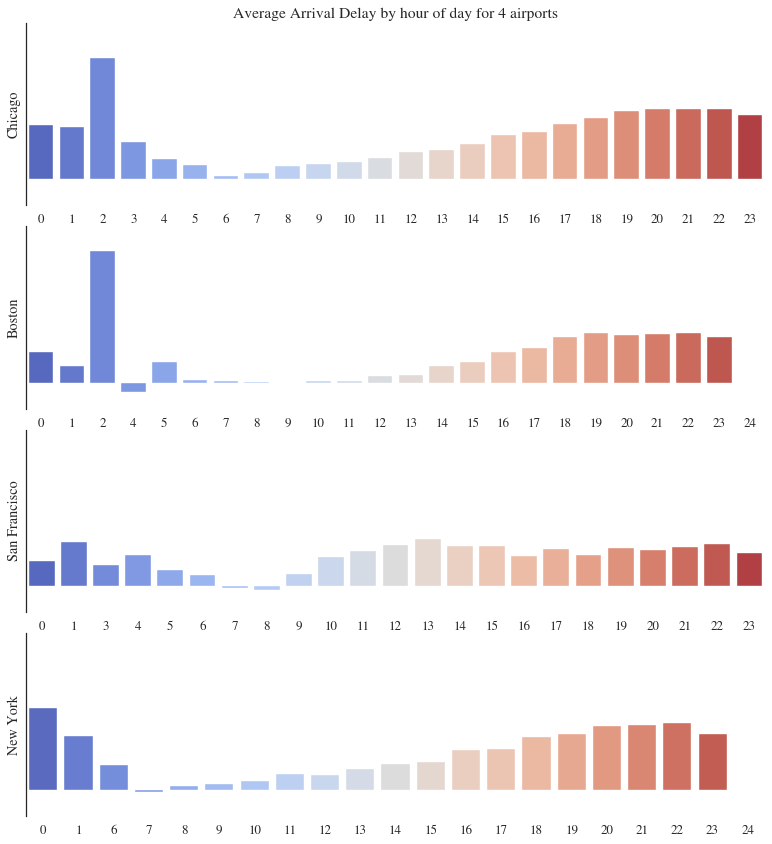

In [114]:
ORD = flt2008ORD[['ArrHr','ArrDelay']].groupby('ArrHr').mean().reset_index()
BOS = flt2008BOS[['ArrHr','ArrDelay']].groupby('ArrHr').mean().reset_index()
SFO = flt2008SFO[['ArrHr','ArrDelay']].groupby('ArrHr').mean().reset_index()
LGA = flt2008LGA[['ArrHr','ArrDelay']].groupby('ArrHr').mean().reset_index()
sns.set(style="white", font='StixGeneral', context="talk")
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(11, 12), sharex=False, sharey=True)

sns.barplot(ORD.ArrHr, ORD.ArrDelay, ci=None, palette="coolwarm", hline=0, ax=ax1)
ax1.set_title('Average Arrival Delay by hour of day for 4 airports')
ax1.set_ylabel('Chicago'); ax1.set_xlabel(''); 
sns.barplot(BOS.ArrHr, BOS.ArrDelay, ci=None, palette="coolwarm", hline=0, ax=ax2)
ax2.set_ylabel('Boston'); ax2.set_xlabel('')
sns.barplot(SFO.ArrHr, SFO.ArrDelay, ci=None, palette="coolwarm", hline=0, ax=ax3)
ax3.set_ylabel('San Francisco'); ax3.set_xlabel('')
sns.barplot(LGA.ArrHr, LGA.ArrDelay, ci=None, palette="coolwarm", hline=0, ax=ax4)
ax4.set_ylabel('New York'); ax4.set_xlabel('')
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])#, xticklabels=Hours)
plt.tight_layout(h_pad=0)

The early morning hours have peak delays again for Chicago and Boston. In both cases, this occurs at 2:00am, with delayed flights arriving  beyond schedule. Generally, as the day wears on, arrival delays increase up until 22:00. It is unclear weather schedule constraints cause the early morning delays (less staff in the early morning) since delays drops off before peaking again. Only San Francisco has a distinct profile with more stable delays throughout the day, with a morning dip from 5:00 amd to 9:00am.

It is obviously that the departure and arrival delay profiles for an airport follow similar shapes. However, the arrival delay distribution shifts to the right for around 2 hours from the departure delay. The average US scheduled flight duration, from 2008 data, is 128 minutes with an average flight distance of 726 miles. The 128 minutes flight duration explains the reason why arrival delay distribution is roughly 2 hours beyond the departure distribution.

Next we look generally at delays linked to carriers, for all airports.

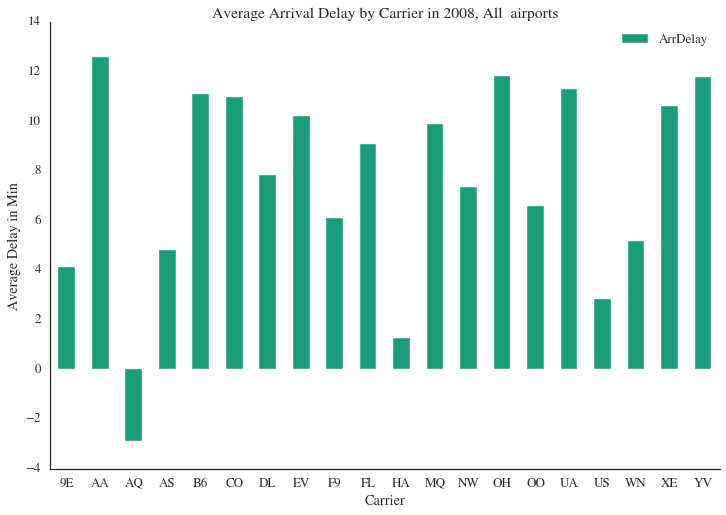

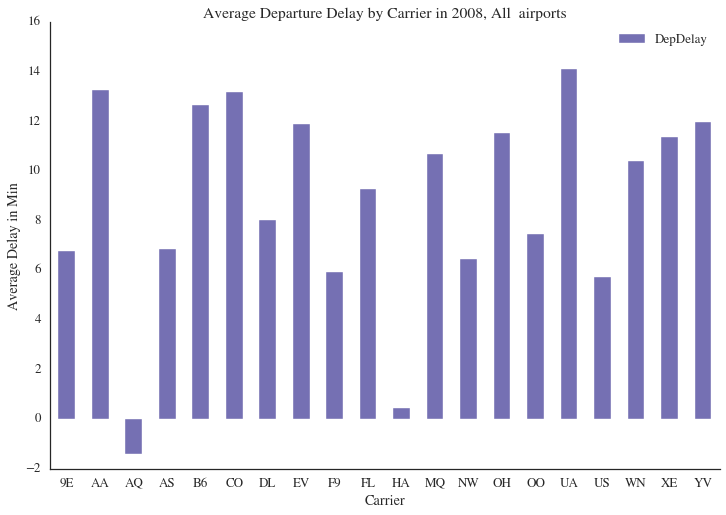

In [115]:
# Examine if specific carrier will create different delay impact
flt2008[['UniqueCarrier','ArrDelay']].groupby('UniqueCarrier').mean().plot(kind='bar', figsize =(12,8), color=dark2_colors[0])
plt.xticks(rotation=0)
plt.xlabel('Carrier')
plt.ylabel('Average Delay in Min')
plt.title('Average Arrival Delay by Carrier in 2008, All  airports')
remove_border()

flt2008[['UniqueCarrier','DepDelay']].groupby('UniqueCarrier').mean().plot(kind='bar', figsize =(12,8), color=dark2_colors[2])
plt.xticks(rotation=0)
plt.xlabel('Carrier')
plt.ylabel('Average Delay in Min')
plt.title('Average Departure Delay by Carrier in 2008, All  airports')
remove_border()


For flights with one of 20 unique carriers, average flight delays vary considerably. The analysis is affected by the number of flights for each carrier. Some, with a small number of flights, like Aloha Airlines (AQ) or Hawaiian Airlines (HA), have lowest mean delays. Both AQ and HA mostly operate flight between Hawaii and Continental United States. Since the flights are mostly 5-6 hours, these flights are usually exempt from Ground Delay Programs (GDPs) when an airport encounter inclement weather conditions. This means that no delay is imposed by air traffic management system. Therefore, the average delays for these two carriers can be quite low.

What if we look at just one airport - Chicago? Does carrier lead to better prediction in this case?

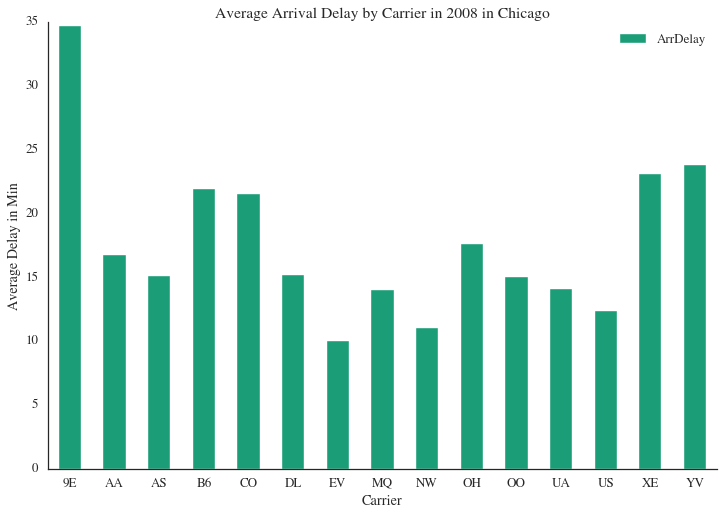

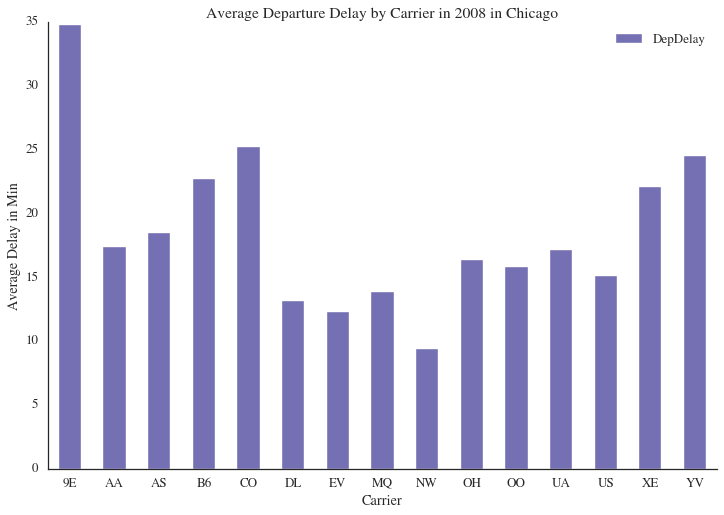

In [116]:
#Chicago Airline Delay by carrier
plt.figure(figsize =(12,8))
flt2008ORD[['UniqueCarrier','ArrDelay']].groupby('UniqueCarrier').mean().plot(kind='bar', figsize =(12,8), color=dark2_colors[0])
plt.xticks(rotation=0)
plt.xlabel('Carrier')
plt.ylabel('Average Delay in Min')
plt.title('Average Arrival Delay by Carrier in 2008 in Chicago')
remove_border()

flt2008ORD[['UniqueCarrier','DepDelay']].groupby('UniqueCarrier').mean().plot(kind='bar', figsize =(12,8), color=dark2_colors[2])
plt.xticks(rotation=0)
plt.xlabel('Carrier')
plt.ylabel('Average Delay in Min')
plt.title('Average Departure Delay by Carrier in 2008 in Chicago')
remove_border()


Here we see that certain carriers, the small ones, have large departure and arrival delays, such as 9E B6, CO, EV and YV. Mainstream carriers like Delta, Northwestern and US Air have smaller delays. Also apparent is that the profile is similar for both departure and arrival delays.

Let's look at the situation for Boston.

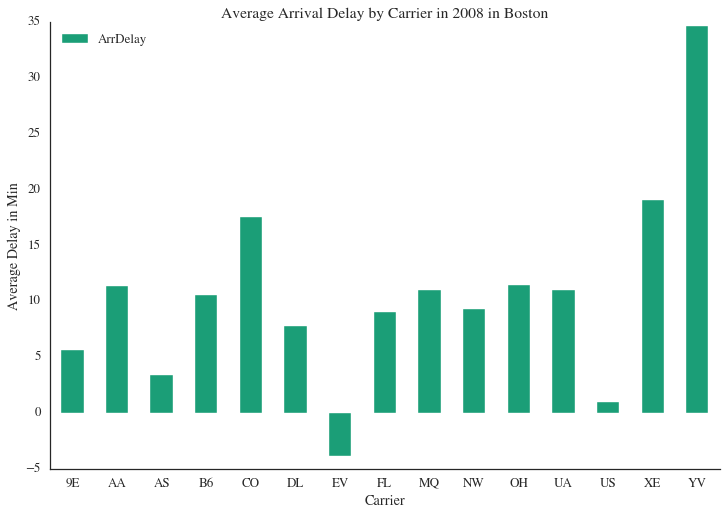

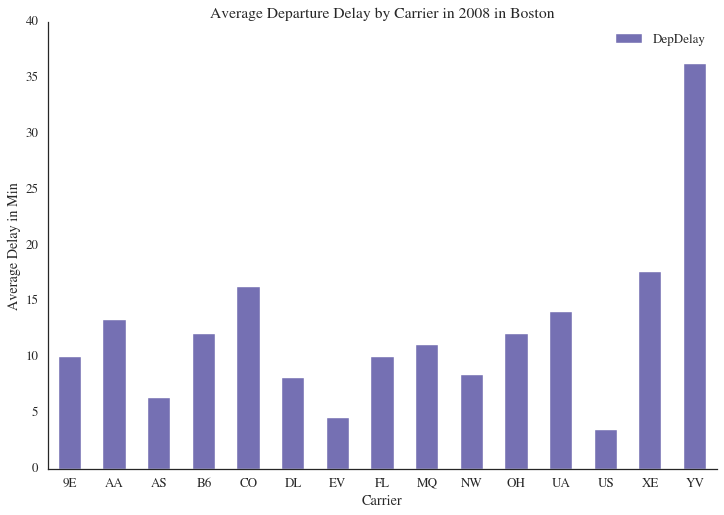

In [117]:
#Boston Airline Delay by carrier
flt2008BOS[['UniqueCarrier','ArrDelay']].groupby('UniqueCarrier').mean().plot(kind='bar', figsize =(12,8), color=dark2_colors[0])
plt.xticks(rotation=0)
plt.xlabel('Carrier')
plt.ylabel('Average Delay in Min')
plt.title('Average Arrival Delay by Carrier in 2008 in Boston')
remove_border()

flt2008BOS[['UniqueCarrier','DepDelay']].groupby('UniqueCarrier').mean().plot(kind='bar', figsize =(12,8), color=dark2_colors[2])
plt.xticks(rotation=0)
plt.xlabel('Carrier')
plt.ylabel('Average Delay in Min')
plt.title('Average Departure Delay by Carrier in 2008 in Boston')
remove_border()


The departure and arrival delay for XE and YV is much longer. With the threshold of 15 minutes mean delay, you can expect a delayed fligh if you are travelling wih CO, XE or YV. In contrast, travelling with EV or US means you can expect to be on time.

However, data exploration may only reveal partial fact at different airports. However, the true causality still requires additional analysis and evaluation using domain judgement.

Let's go beyond the exploratory analysis and build a model for prediction.

*Predictive Models for Flight Delays*
----------------------

Now, we will create several machine learning models to predict flight departure delay delays using 2008 data for flight departures from Chicago O'Hare International Airport (ORD) as an example.

Let us build feature sets for the analysis. This analysis focus on ORD traffic.

There are ways to predict flight departure delay, in this project, instead of predicting the quantity of flight departure delay, we opt to predict if a flight is delayed or not.

1. A flight is on-time if the departure delay is within 15-min of the scheduled departure time (CRSDepTime). 
2. A flight is delayed if the departure delay is more than 15-min late from the scheduled departure time (CRSDepTime).

For flight departure delay prediction, the following features are potential candidates for the model:

    1. Month
    2. Day of Week (weekday vs. weekend)
    3. Departure Hours (convert from CRSDepTime)
    4. Arrival Hours (convert from CRSArrTime)
    5. Departure Airport
    6. Arrival Airport
    7. CRSElapsedTime (total time for a flight)
    8. Flight Distance
    9. Carrier Name

In the following analysis, we will use different models to determine if these features are major contributors to predict  flight departure delay.
    
After this, we will add weather factors at departure and arrival such as:
    1. Total Flight Demand
    2. Airport Meteorological Conditions
        V stands for VMC, and
        I stands for IMC
    3. Airport Temperature


In [118]:
# Identify the columns of the database
# Let us ORD as an example first and expand to other airports
flt2008ORD.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Diverted', 'DepHr', 'ArrHr'], dtype='object')

We would like to build an analysis dataset by choosing the threshold of 15 minutes, beyond which we consider the class change to "Delayed" flight. This is a standard threshold in the aviation industry, with indicators on delayed flights commonly based on 15 minutes of delay.

In the following section, we choose the direction to consider - that is, whether Chicago ORD is the origin or the destination. Additionally, we choose what type of delay to consider ($Ycol$), either Departure delay measured by DepDelay, or the Arrival delay measured by ArrDelay. We can come back to this section to change the choices. We select a subset of columns of most interest ($Xcols$). CRSArrTime will be dropped since the hour is sufficient. Also the TaxiIn and TaxiOut and Diverted variables will be dropped. TailNum is the tail number of the plane and could be interesting in order to match with plane information like number of seats. We will only consider this if time permits, and for now drop it from the dataset.  

Then, we need to factorize the qualitative variables so that the categories are represented by numbers in order to model. We do this for the Carrier and the Airport name categories. 

Since the dataset is so large - we further constrain it so that Python can perform the analysis on our computers in a reasonable amount of time and without crashing. To do so, the dataset is sampled randomly for 20k rows. Further, these observations will be randomly split into training and test sets, so that 10k observation are used for analysis. Also, this training set is scaled so that techniques like PCA and SVM will work. For these purposes the SciKitLearn Standard Scaler is used. It applies the fit transform from the training set to transform the test set so that the prediction will be coherent.

In [119]:
# Build feature sets for our analysis
# separate classes based on 15 minute delay
delay_threshold = 15.
# choose the direction
direction = 'Origin'
#direction = 'Dest'

Ycol = 'DepDelay'

if direction == 'Origin':
    # Features for Departure Delays
    Xcols = ['Month','DayOfWeek','DepHr','ArrHr','UniqueCarrier','Dest','CRSElapsedTime','Distance']
else:
    # Features for Arrival Delays
    Xcols = ['Month','DayOfWeek','DepHr','ArrHr','UniqueCarrier','Origin','CRSElapsedTime','Distance']
    # Specify frames for modelling
    
scaler = StandardScaler()

X_values = flt2008[flt2008[direction] == 'ORD'][Xcols]
Y_values = flt2008[flt2008[direction] == 'ORD'][Ycol]

# Factorise the qualitative variables
X_values['UniqueCarrier'] = pd.factorize(X_values['UniqueCarrier'])[0]

if direction == 'Origin':
    X_values['Dest'] = pd.factorize(X_values['Dest'])[0]
else:
    X_values['Origin'] = pd.factorize(X_values['Origin'])[0]
    

rows = np.random.choice(X_values.index.values, 20000)
sampled_X = X_values.ix[rows]
sampled_Y = Y_values.ix[rows]

TrainX, TestX, TrainY, TestY = train_test_split(
    sampled_X, sampled_Y, test_size=0.50, random_state=0)

TrainX_scl = scaler.fit_transform(TrainX)
TestX_scl = scaler.transform(TestX)

In [135]:
X_values.shape

(335330, 8)

We want to check if there are any remaining null values in the dataset before proceeding. 

In [134]:
print(TestX[pd.isnull(TestX).any(axis=1)].T)
print(TrainX[pd.isnull(TrainX).any(axis=1)].T)

Empty DataFrame
Columns: []
Index: [Month, DayOfWeek, DepHr, ArrHr, UniqueCarrier, Dest, CRSElapsedTime, Distance]
Empty DataFrame
Columns: []
Index: [Month, DayOfWeek, DepHr, ArrHr, UniqueCarrier, Dest, CRSElapsedTime, Distance]


Next, as a first step to data analysis, we do a PCA - to see if the data already can be discriminated using linear methods. A simple skree plot can show how much of the variation is explained by the first principal components. 

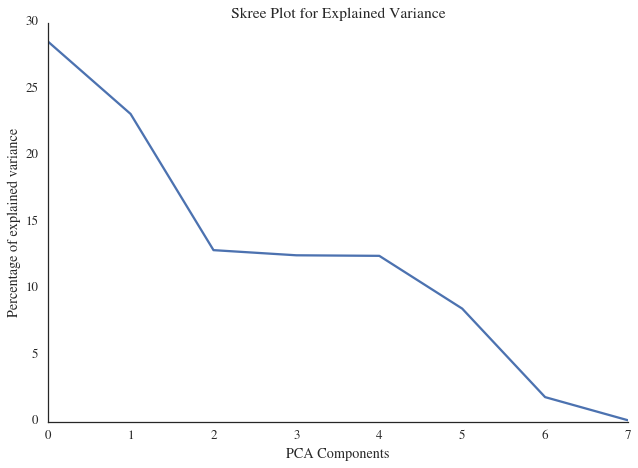

In [121]:
from sklearn.decomposition import PCA

pca = PCA().fit(TrainX_scl, TrainY)
plt.title("Skree Plot for Explained Variance")
plt.ylabel("Percentage of explained variance")
plt.xlabel("PCA Components")
plt.plot(pca.explained_variance_ratio_*100);
remove_border()


In [122]:
sampled_X.columns

Index(['Month', 'DayOfWeek', 'DepHr', 'ArrHr', 'UniqueCarrier', 'Dest', 'CRSElapsedTime', 'Distance'], dtype='object')

The 1st Principal Component explains  28 % of the variance

The 1st and 2nd Principal Components explain  51 % of the variance

The 1st, 2nd and 3rd Principal Components explain  64 % of the variance

[ 28.5913496   51.72179858  64.61098502]

[[ -2.43582155e-04   6.46777470e-03  -3.85247631e-02   1.68063877e-02
    2.32422875e-01   4.03077568e-01   6.24356388e-01   6.26002140e-01]
 [  1.38905454e-02  -6.04034529e-03  -7.05962341e-01  -7.07320685e-01
   -2.99355546e-02   4.24408089e-03  -1.26243499e-02  -3.41527239e-03]
 [ -8.09639213e-02   2.94272594e-01   9.15131345e-03   1.09925321e-02
   -7.74569326e-01  -3.99333629e-01   2.71611429e-01   2.71009495e-01]]


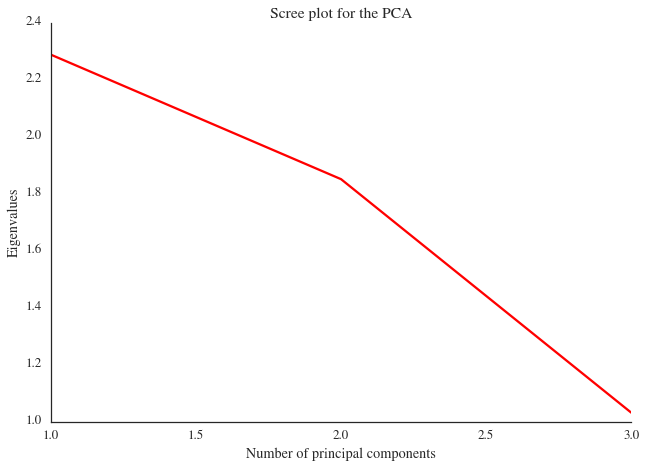

In [123]:
svd = sklearn.decomposition.TruncatedSVD(n_components=3)
TrainX_2d = svd.fit_transform(TrainX_scl)

# we make a scree plot to see how many Principal Components to consider
#fig = plt.figure(figsize=(12, 6))
eig = svd.explained_variance_
# and calculate the variance explained by the PC analysis
var_exp = svd.explained_variance_ratio_.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
remove_border()

print('The 1st Principal Component explains ', var_exp[0].astype(int), '% of the variance')
print('')
print('The 1st and 2nd Principal Components explain ', var_exp[1].astype(int), '% of the variance')
print('')
print('The 1st, 2nd and 3rd Principal Components explain ', var_exp[2].astype(int), '% of the variance')


print('')
print(var_exp)

print('')
print(svd.components_)
#print(eig)

The first two PC explain over 50% of the varaition. The blue skree plot line shows that the skree is basically from the second PC and is substantial to about PC 5. This means that we can use just 2 components, but that the characterization will not be complete since it only will show the about 50% of the variation. We need to go into higher orders to have a better characterization. Going to 3 PCs will improve, reaching 64% of the variance explained. 

If we plot out the points scattered according to coefficients of the first two PCs and color by the class of the points, we may see some class boundaries.

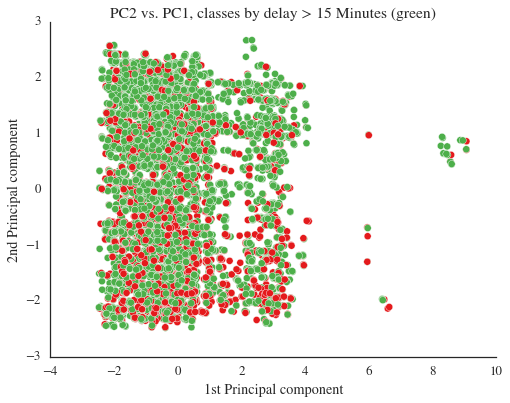

In [124]:
plt.set_cmap(plt.cm.Paired)
cmap=plt.cm.Paired
Pltcolors = cmap([0,1,2])
 
plt.figure(figsize=(8, 6))    
plt.scatter(TrainX_2d[:,0], TrainX_2d[:,1], c=(TrainY >= delay_threshold), s = 50, cmap=cmap_set1)
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.title("PC2 vs. PC1, classes by delay > 15 Minutes (green)")
remove_border()


The scatterplot shows that green (>15 minute delay) are perhaps higher  on the 2nd component, with this component separating only marginally. The first component separates two small clusters at coefficients of 6 and 8. There are only a few points in each. This is likely because PC1 is mostly flight distance and duration and these are the longest flights.

Let's plot the 3rd against 1st PC to see if there is better separation on classes.

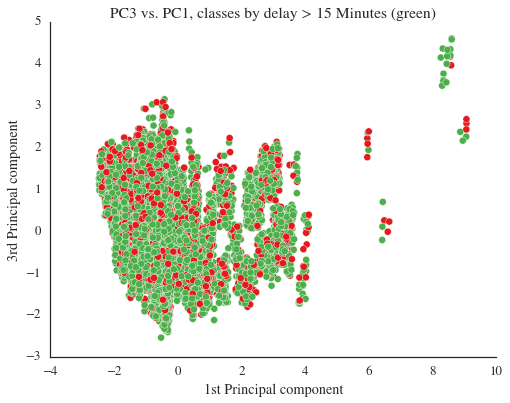

In [125]:
plt.set_cmap(plt.cm.Paired)
cmap=plt.cm.Paired
Pltcolors = cmap([0,1,2])
 
plt.figure(figsize=(8, 6))    
plt.scatter(TrainX_2d[:,0], TrainX_2d[:,2], c=(TrainY >= delay_threshold), s = 50, cmap=cmap_set1)
plt.ylabel('3rd Principal component' )
plt.xlabel('1st Principal component' )
plt.title("PC3 vs. PC1, classes by delay > 15 Minutes (green)")
remove_border()


We can clearly imagine a hyperplane separating the small clusters here. We can again see the PC1 separating the clusters at coefficients 6 and 8. The separation of red and green color has become worse. Clearly these PC may be used to separate the classes, but it is not clear the they do so effectively based on the arbitrary cut-off value of 15 minutes. 

Once again we don't see a clear separation of classes now that the classes represent delays in minutes. 

Next we preform a Least-Squares linear regression estimation on the model. 

In [127]:
X = sm.add_constant(pd.DataFrame(TrainX_scl, columns=[Xcols]))

Y = pd.DataFrame(TrainY, columns=['DepDelay'])
Y_new = pd.DataFrame(TestY, columns=['DepDelay'])
Y = Y.reset_index(drop=True)
Y_new = Y_new.reset_index(drop=True)

print(Y.shape)
print(X.shape)
res_full = sm.OLS(Y,X).fit()

res_full.summary()
print(res_full.summary())

X_new = sm.add_constant(pd.DataFrame(TestX_scl, columns=[Xcols]))

np.mean((res_full.predict(X_new)-Y_new.values)**2)

(10000, 1)
(10000, 9)
                            OLS Regression Results                            
Dep. Variable:               DepDelay   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     70.90
Date:                Sat, 24 Sep 2016   Prob (F-statistic):          5.13e-114
Time:                        13:31:35   Log-Likelihood:                -51132.
No. Observations:               10000   AIC:                         1.023e+05
Df Residuals:                    9991   BIC:                         1.023e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             17.3

1860.0566753250864

In [128]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X.values, Y.values)

print('Estimated intercept coefficient:', lm.intercept_)
print('Adjusted R^2 of the regression:',  lm.score(X.values, Y.values))
#pd.DataFrame(zip(['Int.']+Xcols, lm.coef_[0].T.tolist()), columns = ['Features', 'Estimated Coefficients'])[1:]
pd.DataFrame(list(zip(['Int.']+Xcols, lm.coef_[0].T.tolist())), columns = ['Features', 'Estimated Coefficients'])[1:]

Estimated intercept coefficient: [ 17.3423]
Adjusted R^2 of the regression: 0.0537242098795


,Features,Estimated Coefficients
1,Month,-4.070026
2,DayOfWeek,-1.369794
3,DepHr,7.639350
4,ArrHr,0.568276
5,UniqueCarrier,-1.339306
6,Dest,-1.120862
7,CRSElapsedTime,8.131376
8,Distance,-5.920245


** *Check which features have the most explainatory power on this subset* **

In the biggest model, it looks like Destination has the least explanatory power, followed by the DayofWeek and the UniqueCarrier. In the full model, the coefficient on Destination is not significantly different from zero, nor is the one for ArrHr. The Adjusted R2 is just over 5%, which is really not a good indicator - we would like our model to have more explanatory power. We can try a smaller model, dropping DayofWeek, Destination and Carrier.

In [129]:
from sklearn.linear_model import LinearRegression
lm2 = LinearRegression()
lm2.fit(X.values[:,[0,1,3,4,7,8]], Y.values)

print('Estimated intercept coefficient:', lm2.intercept_)
print('Adjusted R^2 of the regression:',  lm2.score(X.values[:,[0,1,3,4,7,8]], Y.values))
pd.DataFrame(list(zip(['Int.']+['Month','DepHr','ArrHr','CRSElapsedTime','Distance'], lm2.coef_[0].T.tolist())), columns = ['Features', 'Estimated Coefficients'])[1:]

Estimated intercept coefficient: [ 17.3423]
Adjusted R^2 of the regression: 0.0506232945404


,Features,Estimated Coefficients
1,Month,-4.076902
2,DepHr,7.776332
3,ArrHr,0.406597
4,CRSElapsedTime,8.408451
5,Distance,-6.813377


The adjusted R2 decreased, showing that the alternative model does not explain as much variation. We would like to keep all the original variables. Let's look a little more closely at the attributes themselves and how they are related to the classes. We will use scatterlots and plot each variable against delay. Then, since we have a large number of attributes, the best would be a parallel coordinates plot of the attributes, coloring by class. We will do both.

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<function matplotlib.pyplot.show>

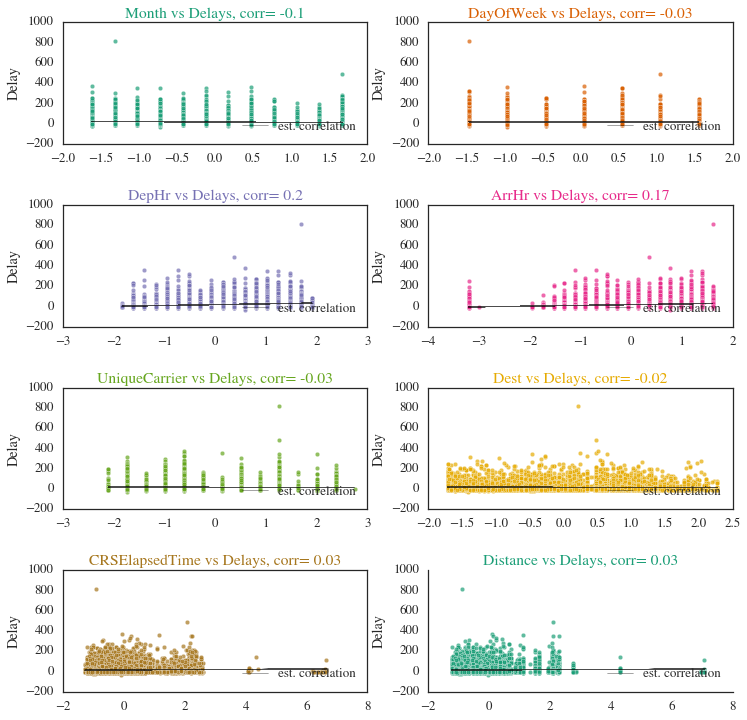

In [130]:
fig, ax = plt.subplots(4, 2, figsize=(12,12))
for i, k, l in zip(np.arange(len(Xcols)), Xcols,  Xcols):
    correl = round(np.corrcoef(X[k], Y.values[:,0])[0][1],2)
    axX = np.floor(i/2)
    axY = (i % 2 != 0) * 1
    corline = np.polyfit(X[k], Y.values[:,0],1)
    corr_line = np.poly1d(corline)
    ax[axX, axY].scatter(X[k], Y.values[:,0] , alpha = 0.7, c = dark2_colors[i])
    ax[axX, axY].plot(X[k], corr_line(X[k]), '-', alpha = 0.7, c = 'black', linewidth=.5 , label='est. correlation')
    remove_border()
    ax[axX, axY].set_title(l + ' vs Delays, corr= '+ str(correl), color = dark2_colors[i])
    ax[axX, axY].legend(frameon=False, loc='lower right')
    ax[axX, axY].set_ylabel('Delay')
i += 1
plt.show

The scatterplots reveal some relationships, but they need close reading. None of them show a clear correlation. In fact, the highest correlation coefficient is for ArrivalHour, because of the time of day effect that was noted earlier. This confounded by the early morning delays - which cause a spike at the lower end in the scatterplot. Also, Carrier and Month show some correlation which confirms what we say in the column plots above on for the full dataset. The bottom two plots reveal the seperated clumps that we say above in the PC scatterplots. It is clear with these scatterplots that PC1 is capturing the duration and distance characteristics mainly. These may be correlated to delay, but in fact negatively - because with longer distance there is less delay since the flights are prioritized for take-off and the longer duration allow them to make up tardy departures. So we see that long-haul are less likely to be delayed.

In [137]:
# plot confustion matrix function
def show_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()

    target_names = ['Not Delayed', 'Delayed']

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Convenience function to adjust plot parameters for a clear layout.
    plt.show()

Next, we move on to classification. The first model is a logistic regression model with L2 penalty function. We fit the training model that we randomly split 50-50 above. It is a fairly 'vanilla' classification that we shall use as a benchmark. Given the OLS estimation above, we are not sure that the linear regression model is the best choice for our problem but it is good to evaluate against in terms of accuracy.

In [138]:
# logistic regression classification model
clf_lr = sklearn.linear_model.LogisticRegression(penalty='l2', class_weight='auto')
logistic_fit=clf_lr.fit(TrainX, np.where(TrainY >= delay_threshold,1,0))

pred = clf_lr.predict(TestX)

C:\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Confusion matrix
      0     1
0  4346  2815
1  1102  1737


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)



precision = 0.38, recall = 0.61, F1 = 0.47, accuracy = 0.61

          0         1
0  0.606898  0.991546
1  0.153889  0.611835


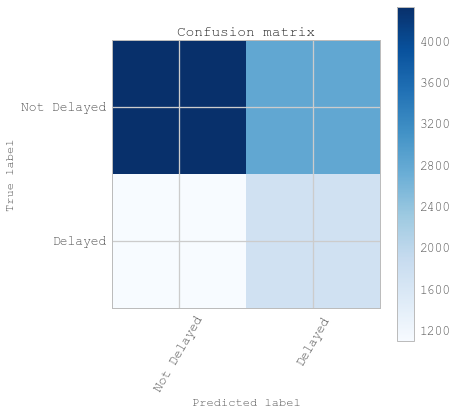

In [139]:
# print results
cm_lr = confusion_matrix(np.where(TestY >= delay_threshold,1,0), pred)
print("Confusion matrix")
print(pd.DataFrame(cm_lr))
report_lr = precision_recall_fscore_support(list(np.where(TestY >= delay_threshold,1,0)), list(pred), average='micro')
print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_lr[0], report_lr[1], report_lr[2], accuracy_score(list(np.where(TestY >= delay_threshold,1,0)), list(pred))))
print(pd.DataFrame(cm_lr.astype(np.float64) / cm_lr.sum(axis=1)))
    
show_confusion_matrix(cm_lr)


The accuracy score of 61% is already encouraging, meaning that even this first classification model guesses right 61% of the time, better than a coin flip. We know  that the positive case of a delay of more than 15 minutes is less frequent than no delay (around 2800 delayed cases to more than 7000 for no delay), so we may prefer to look at the F1 measure, which is 47% here.

We turn to a Random Forest classification. In order to choose the optimal number of trees, we classify using 1 to 50 trees and look at the mean, median and dispersion of the resulting accuracy measures. 

In [140]:
# set the number of input variables, m - use a rule of thumb for classification. 
# sqrt of the number of original features

Ntrees = 50
Trees = np.arange(Ntrees)+1
m = np.sqrt(TrainX.shape[1]).astype(int)
cv = 10

clf_scores = np.zeros((Ntrees,cv))

for tree in Trees:
    cols = (tree - 1)
    clf = ensemble.RandomForestClassifier(n_estimators=tree, max_features=m, random_state=0,n_jobs=-1)
    clf_scores[cols,:] = cross_validation.cross_val_score(clf, TrainX, np.where(TrainY >= delay_threshold,1,0), 
                                                          cv=cv, scoring = 'accuracy' , n_jobs = -1)


In [141]:
clf_scores.shape

(50, 10)

AssertionError: Grouper and axis must be same length

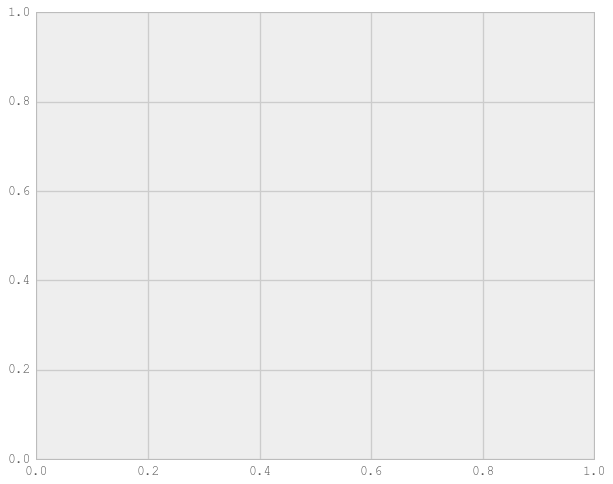

In [143]:
plt.subplots(figsize=(10,8))
score_means = np.mean(clf_scores, axis=1)
score_std = np.std(clf_scores, axis=1)
score_medians = np.median(clf_scores, axis=1)
sns.boxplot(clf_scores.T, Trees);

plt.scatter(Trees,score_means, c='k', zorder=3, label= 'Mean of accuracy scores')
plt.errorbar(Trees, score_means, yerr = 2*score_std,color='#31a354', alpha =0.7, capsize=20, elinewidth=4, 
             linestyle="None", zorder = 1, label= 'SE of accuracy scores')
plt.title('Accuracy by choice of number of trees')
plt.legend(frameon=False, loc='lower right')
plt.ylabel('Accuracy Scores')
plt.xlabel('Number of trees in the Random Forest')
plt.xticks(rotation=90)
remove_border()
plt.show

<function matplotlib.pyplot.show>

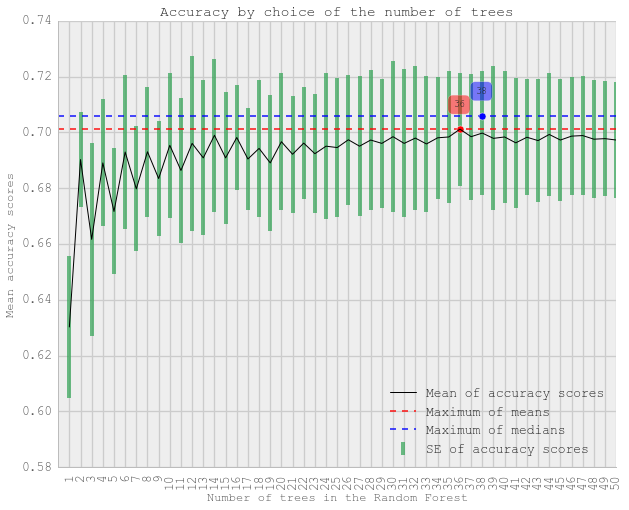

In [144]:
plt.subplots(figsize=(10,8))
plt.hlines(np.max(score_means),0, 51, linestyle='--', color='red', linewidth=2, alpha=0.7,  zorder = 2, label= 'Maximum of means')
plt.hlines(np.max(score_medians),0, 51, linestyle='--',color='blue', linewidth=2, alpha=0.7,  zorder = 2, label= 'Maximum of medians')
plt.scatter((np.argmax(score_means)+1),np.max(score_means), s=50, c='red', marker='o', zorder=3)
plt.scatter((np.argmax(score_medians)+1),np.max(score_medians), s=50, c='blue', marker='o', zorder=3)
plt.plot(Trees,score_means, zorder=3, c= 'k', label= 'Mean of accuracy scores')
plt.errorbar(Trees, score_means, yerr = 2*score_std,color='#31a354', alpha =0.7, capsize=20, elinewidth=4, linestyle="None", zorder = 1, label= 'SE of accuracy scores')
plt.annotate((np.argmax(score_medians)+1), 
    xy = ((np.argmax(score_medians)+1), np.max(score_medians)), 
    xytext = (5, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'blue', alpha = 0.5))
plt.annotate((np.argmax(score_means)+1), 
    xy = ((np.argmax(score_means)+1), np.max(score_means)), 
    xytext = (5, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5))
plt.title('Accuracy by choice of the number of trees')
plt.legend(frameon=False, loc='lower right')
plt.ylabel('Mean accuracy scores')
plt.xlabel('Number of trees in the Random Forest')
plt.xlim(0, 41)
plt.xticks(Trees,rotation=90)
remove_border()
plt.show

In [145]:
Ntrees2 = 50
Trees2 = np.arange(Ntrees2)+1
clf_OOBscores = np.zeros((Ntrees2))

for tree in Trees2:
    cols = (tree - 1)
    clf = ensemble.RandomForestClassifier(n_estimators=tree, oob_score=True, max_features=m, random_state=0, n_jobs=-1)
    clf.fit(TrainX, np.where(TrainY >= delay_threshold,1,0))
    clf_OOBscores[cols] = clf.oob_score_

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklea

<function matplotlib.pyplot.show>

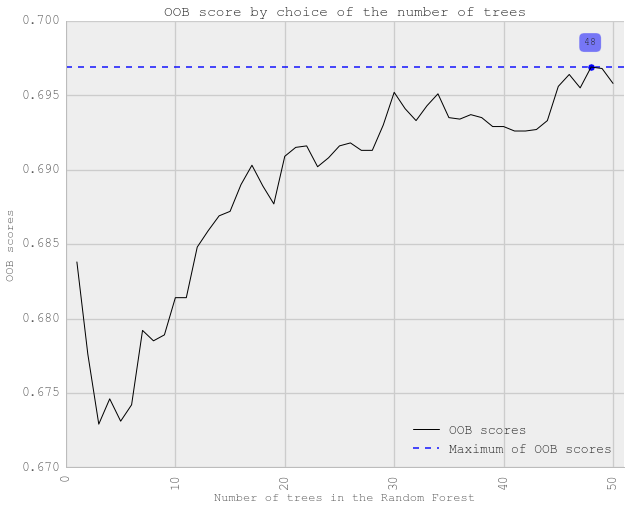

In [146]:
plt.subplots(figsize=(10,8))
plt.hlines(np.max(clf_OOBscores),0, 51, linestyle='--',color='blue', linewidth=2, alpha=0.7,  zorder = 2, label= 'Maximum of OOB scores')
plt.scatter((np.argmax(clf_OOBscores)+1),np.max(clf_OOBscores), s=50, c='blue', marker='o', zorder=3)
plt.plot(Trees2,clf_OOBscores, zorder=3, c= 'k', label= 'OOB scores')
plt.annotate((np.argmax(clf_OOBscores)+1), 
    xy = ((np.argmax(clf_OOBscores)+1), np.max(clf_OOBscores)), 
    xytext = (5, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'blue', alpha = 0.5))
plt.title('OOB score by choice of the number of trees')
plt.legend(frameon=False, loc='lower right')
plt.ylabel('OOB scores')
plt.xlabel('Number of trees in the Random Forest')
plt.xlim(0, 51)
plt.xticks(rotation=90)

remove_border()
plt.show

So based on the optimal choice of the number of trees, we classify again, saving the confusion matrix information. We see that the accuracy improves compared to the LR model, rising to 71%. While we are better classifying the flights that are not delayed, we are also classifying more delayed flights as not-delayed (our false positive rate went up). The F1 score goes down.

In [147]:
# Create Random Forest classifier with 50 trees
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf_rf.fit(TrainX, np.where(TrainY >= delay_threshold,1,0))

# Evaluate on test set
pred = clf_rf.predict(TestX)

Confusion matrix
      0    1
0  6170  991
1  1969  870

precision = 0.47, recall = 0.31, F1 = 0.37, accuracy = 0.70

          0         1
0  0.861612  0.349067
1  0.274962  0.306446


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


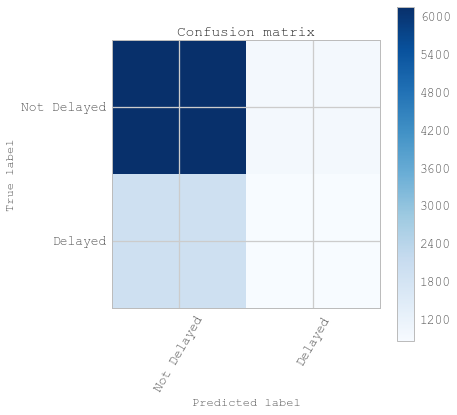

In [148]:
# print results
cm_rf = confusion_matrix(np.where(TestY >= delay_threshold,1,0), pred)
print("Confusion matrix")
print(pd.DataFrame(cm_rf))
report_rf = precision_recall_fscore_support(list(np.where(TestY >= delay_threshold,1,0)), list(pred), average='micro')
print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], accuracy_score(list(np.where(TestY >= delay_threshold,1,0)), list(pred))))
print(pd.DataFrame(cm_rf.astype(np.float64) / cm_rf.sum(axis=1)))
    
show_confusion_matrix(cm_rf)

The left-hand side of the matrix is darker than the right, showing that the RF classifier guesses 'not delayed' more often than delayed. We are happy with the improvement in accuracy, but wondering how to improve the precision and the F1 score. 

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


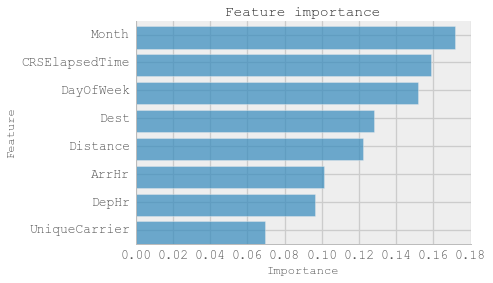

In [149]:
importances = pd.Series(clf_rf.feature_importances_, index=Xcols)
importances.sort()

plt.barh(np.arange(len(importances)), importances, alpha=0.7)
plt.yticks(np.arange(.5,len(importances),1), importances.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance')
remove_border()
plt.show()

From the feature importance measures, we see that month and day of the week have high importance, followed by the duraton and distance. Even though we have shown that ArrHr is closely linked to delay, it is not at the top of the importance chart.

We want to look at cross-validation to get an indication of the variation in accuracy scores for the choice of number of trees. We cross-validate with 10 random folds on the training data and check the mean score as well as the minimum and maximum scores.  

In [150]:
clf_rf = RandomForestClassifier(n_estimators=45, n_jobs=-1)
RF_scores = cross_validation.cross_val_score(clf_rf, TrainX, np.where(TrainY >= delay_threshold,1,0), cv=10, scoring='accuracy')
RF_scores

array([ 0.71328671,  0.711     ,  0.684     ,  0.696     ,  0.705     ,
        0.678     ,  0.707     ,  0.709     ,  0.7       ,  0.69169169])

In [151]:
RF_scores.min(), RF_scores.mean(), RF_scores.max()

(0.67800000000000005, 0.69949784049784047, 0.71328671328671334)

We can expect a best accuracy of 72% with this model and choice of number of trees.

Next we would like to consider a SVM classifier - first taking what might be considered a 'vanilla' choice of tuning parameters and RBF kernel, where C=100 and gamma= 0.0001.  

In [152]:
from sklearn.svm import SVC
svc =  SVC(kernel='rbf', C=100, gamma=0.001).fit(TrainX_scl, np.where(TrainY >= delay_threshold,1,0))
SVC_scores = cross_val_score(svc, TrainX_scl, np.where(TrainY >= delay_threshold,1,0), cv=10, scoring='accuracy', n_jobs=-1) 
SVC_scores

array([ 0.71028971,  0.711     ,  0.711     ,  0.711     ,  0.711     ,
        0.711     ,  0.711     ,  0.711     ,  0.711     ,  0.71071071])

In [153]:
SVC_scores.min(), SVC_scores.mean
(), SVC_scores.max()

((), 0.71099999999999997)

The SVM classifer does not seem to improve the performance by too much, with scores close to the RF classifier. The SVM requires a much longer time to compute. Given the small performance gain we try to tune the SVM parameters, concentrating on the gamma parameter. We use a validation curve plotter on the results from the SciKit ShuffleSplit routine using 10 values of gamma ranged from 10e-5 to 10e5.

In [154]:
from sklearn.learning_curve import validation_curve
n_samples, n_features = TrainX_scl.shape
cv = ShuffleSplit(n_samples, n_iter=10, train_size=500, test_size=500, random_state=0)
n_Cs = 10
Cs = np.logspace(-5, 5, n_Cs)

SVC_train_scores, SVC_test_scores = validation_curve(
    SVC(gamma=0.0001), TrainX_scl,np.where(TrainY >= delay_threshold,1,0), 'C', Cs, cv=cv)

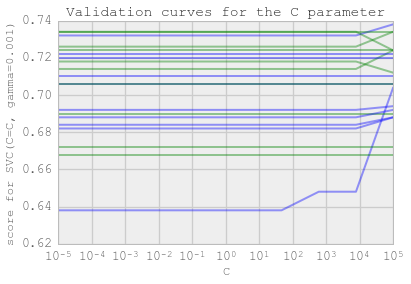

In [155]:
def plot_validation_curves(param_values, train_scores, test_scores):
    for i in range(train_scores.shape[1]):
        plt.semilogx(param_values, train_scores[:, i], alpha=0.4, lw=2, c='b')
        plt.semilogx(param_values, test_scores[:, i], alpha=0.4, lw=2, c='g')

plot_validation_curves(Cs, SVC_train_scores, SVC_test_scores)
plt.ylabel("score for SVC(C=C, gamma=0.001)")
plt.xlabel("C")
plt.title('Validation curves for the C parameter');

Based on the results and the validation curves, we don't find that varying the gamma parameter will improve the model performance much. Given the results, we find that look at improving the RF classifier model is the best path to follow, next by encoding the qualitative variables into dummy variables that we had factorized previously into category numbers. SciKit Learn has a OneHotEncoder routine that we can use for this. The advantage is that we can quickly transform the test variables based on the same encoding. By encoding the variables as dummies, the number of variables increases substantially.  

In [156]:
# Use SciKitLearn OneHotEncoder to see if the model is improved
from sklearn.preprocessing import OneHotEncoder
categ = [Xcols.index(x) for x in ('Month', 'DayOfWeek', 'UniqueCarrier', 'Dest')]
encoder = OneHotEncoder(categorical_features = categ)
TrainXenc = encoder.fit_transform(TrainX).toarray()
TestXenc = encoder.transform(TestX).toarray()

In [157]:
# Create Random Forest classifier with 50 trees
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf_rf.fit(TrainXenc, np.where(TrainY >= delay_threshold,1,0))

# Evaluate on test set
pred = clf_rf.predict(TestXenc)

Confusion matrix
      0    1
0  6377  784
1  1986  853

precision = 0.52, recall = 0.30, F1 = 0.38, accuracy = 0.72

          0         1
0  0.890518  0.276154
1  0.277336  0.300458


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


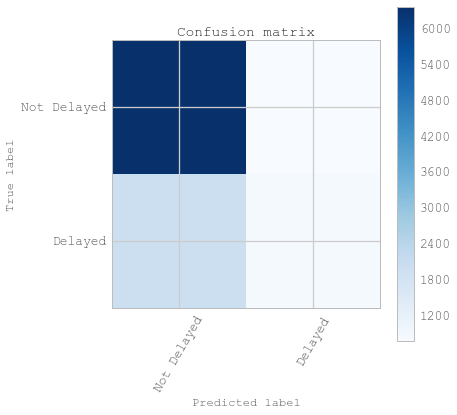

In [158]:
# print results
cm_rf = confusion_matrix(np.where(TestY >= delay_threshold,1,0), pred)
print("Confusion matrix")
print(pd.DataFrame(cm_rf))
report_rf = precision_recall_fscore_support(list(np.where(TestY >= delay_threshold,1,0)), list(pred), average='micro')
print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], accuracy_score(list(np.where(TestY >= delay_threshold,1,0)), list(pred))))
print(pd.DataFrame(cm_rf.astype(np.float64) / cm_rf.sum(axis=1)))
    
show_confusion_matrix(cm_rf)

The dummy encoding improved the accuracy score to 72%. Precision improved slightly and the F1 did not change. It seems that dummy encoding provides marginal performance gains. As for next steps, we need to look at adding explanatory variables. We will take weather data and merge it to the 2008 database and then repeat the same steps.

** *Input and Process Weather Data* **
----------------------------------------

In addition to using flight data to predict flight departure delay, additional database is incorporated in the following section hoping for better predictability.

*** FAA Airline Operations Performance Data ***

The Aviation System Performance Metrics (ASPM) data from the FAA operations performance data (https://aspm.faa.gov/) website contains airport specific weather, flight demand and airport capacity information. Detailed ASPM data description can be found here (http://aspmhelp.faa.gov/index.php/Aviation_Performance_Metrics_%28APM%29).


The Aviation System Performance Metrics (ASPM) online access system provides data on flights to and from the ASPM airports (currently 77) in the United States; and all flights by the ASPM carriers, including flights by those carriers to international and domestic non-ASPM airports. All IFR traffic, and some Visual Flight Rules (VFRs) traffic for these carriers and airports is included.

The data used in this project is from 2008. It contains hourly weather and operational data for 77 US airports. A detailed data fields is listed below:

<h3>Flight Level Data: Definitions of Variables</h3>
<h3> Date/Period Information </span></h3>
<ul><li><b>Dep_YYYYMM.</b> Scheduled Departure Year and Month (Local Date).
</li><li><b>Dep_DAY.</b> Scheduled Departure Day (Local Day).
</li><li><b>Dep_HOUR.</b> Scheduled Departure Hour (Local Hour). 
</li><li><b>Dep_QTR.</b> Scheduled Departure Quarter Hour (Local Qtr). 
</li><li><b>Arr_YYYYMM.</b> Scheduled Arrival Year and Month (Local Date). 
</li><li><b>Arr_DAY.</b> Scheduled Arrival Day (Local Day).
</li><li><b>Arr_HOUR.</b> Scheduled Arrival Hour (Local Hour). 
</li><li><b>Arr_QTR.</b> Scheduled Arrival Quarter Hour (Local Qtr). 
</li><li><b>Off_YYYYMM.</b> Actual Wheels Off Year and Month (ASQP/OOOI Off Local Date).
</li><li><b>Off_DAY.</b> Actual Wheels Off Day (ASQP/OOOI Off Local Day).
</li><li><b>Off_HOUR.</b> Actual Wheels Off Hour (ASQP/OOOI Off Local Hour). 
</li><li><b>Off_QTR.</b> Actual Wheels Off Quarter Hour (ASQP/OOOI Off Local Qtr). 
</li><li><b>On_YYYYMM.</b> Actual Wheels On Year and Month (ASQP/OOOI On Local Date). 
</li><li><b>On_DAY.</b> Actual Wheels On Day (ASQP/OOOI On Local Day).
</li><li><b>On_HOUR.</b> Actual Wheels On Hour (ASQP/OOOI On Local Hour). 
</li><li><b>On_QTR.</b> Actual Wheels On Quarter Hour (ASQP/OOOI On Local Qtr). 
</li></ul>
<p><br />
</p>
<h3> <span class="mw-headline" id="Flight_Identification"> Flight Identification </span></h3>
<ul><li><b>FAACARRIER.</b> Flight Carrier Code - ICAO.
</li><li><b>FLTNO.</b> Flight Number (2385 = 2385A).
</li><li><b>TAILNO.</b> Aircraft Tail Number (from ASQP). 
</li><li><b>ETMS_EQPT.</b> IATA Aircraft Equipment Code from ETMS. 
</li><li><b>Dep_LOCID.</b> Departure Location Identifier: Domestic = space +  3-character identification code, foreign = ICAO 4-character identification code.
</li><li><b>Arr_LOCID.</b> Arrival Location Identifier: Domestic = space +  3-character identification code, foreign = ICAO 4-character identification code. 
</li><li><b>OOOI.</b> ARINC OOOI/ASQP Present? (Y=Yes, N=No). 
</li><li><b>ETMS.</b> ETMS Present? (Y=Yes, N=No). 
</li><li><b>OAG.</b> OAG Present? (Y=Yes, N=No). 
</li><li><b>FLTTYPE.</b> Flight Type: D = Domestic dep, foreign arr; N = Domestic dep and arr; A = Foreign dep, domestic arr.
</li><li><b>OAG_ACID.</b> Flight Schedule Data System(FSDS) - Carrier and Fltno links to matching schedule record, or it will contain “ASQP” if from ASQP. 
</li><li><b>USER_CLASS.</b> Aircraft Class: C = Commercial; T = Air Taxi; F = Freight; G = General Aviation; M = Military; O = Other.
</li></ul>
<h3> <span class="mw-headline" id="Departure_Information"> Departure Information </span></h3>
<p><b>Departure Gate Data</b>
</p>
<ul><li><b>OAG_S_DEP (SchOutSec).</b> Scheduled Gate Departure (GMT Seconds since 1/1/80). 
</li><li><b>T_OAG_S_DE (SchOutTm).</b> Scheduled Gate Departure Time (Local) HH:MM.
</li><li><b>FILED_PTIM (FPDepSec).</b> Flight Plan Gate Departure GMT Seconds since 1/1/80. 
</li><li><b>T_FIL_PTIM (FPDepTm).</b> Flight Plan Gate Departure Time HH:MM.
</li><li><b>OOOI_DEP (ActOutSec).</b> Actual Gate Out GMT Seconds since 1/1/80. 
</li><li><b>T_OOOI_DEP (ActOutTm).</b> Actual Gate Out Time HH:MM.
</li></ul>
<p><br />
<b>Taxi Out Data</b>
</p>
<ul><li><b>NOM_TO.</b> Nominal - Unimpeded Taxi Out Time in Minutes. 
</li><li><b>TAXI_OUT (ActTO).</b> Taxi Out in Minutes.
</li></ul>
<p><br />
<b>Wheels Off Data</b> 
</p>
<ul><li><b>OAG_OFF (SchOffSec).</b> Scheduled Wheels Off Seconds since 1/1/80. 
</li><li><b>T_OAG_OFF (SchOffTm).</b> Scheduled Wheels Off Time HH:MM.
</li><li><b>PTIM_OFF (FPOffSec).</b> Flight Plan Wheels Off Seconds since 1/1/80. 
</li><li><b>T_PTIM_OFF (FPOffTm).</b> Flight Plan Wheels Off Time HH:MM.
</li><li><b>PLAN_OFF (ETMSOffSec).</b> ETMS Plan Wheels Off GMT Seconds since 1/1/80. 
</li><li><b>T_PLAN_OFF (ETMSOffTm).</b> ETMS Plan Wheels Off Time HH:MM.
</li><li><b>EDCT_OFF (EDCTOffSec).</b> EDCT Wheels Off GMT Seconds since 1/1/80. 
</li><li><b>T_EDCT_OFF (EDCTOffTm).</b> EDCT Wheels Off Time HH:MM.
</li><li><b>WHEELS_OFF (ActOffSec).</b> Actual Wheels Off GMT Seconds since 1/1/80. 
</li><li><b>T_WHLS_OFF (ActOffTm).</b> Actual Wheels Off Time HH:MM.
</li><li><b>ACT_DZ (DZSec).</b> ETMS Departure Message GMT Seconds since 1/1/80. 
</li><li><b>T_ACT_DZ (DZTm).</b> ETMS Departure Message Time HH:MM.
</li><li><b>GAP_DZ.</b> Minutes Between Wheels Off and DZ Message.
</li></ul>
<p><br />
<b>Departure Delay Data</b>
</p>
<ul><li><b>O_GATE_DEL (DlaSchOut).</b> Gate Delay in Minutes (Based on Schedule).
</li><li><b>GATE_DELAY (DlaFPOut).</b> Gate Delay in Minutes (flight plan based).
</li><li><b>EDCT_HOLD (DlaEDCT).</b> EDCT Hold in Minutes.
</li><li><b>DELAY_TO (DlaTO).</b> Taxi Out Delay Minutes.
</li><li><b>OAG_ARPT_DEP (DlaSchOff).</b> Airport Departure Delay Minutes (Based on Schedule). 
</li><li><b>PTM_ARPT_DEP (DlaFPOff).</b> Airport Departure Delay Minutes (Based on Flight Plan).
</li></ul>
<p><br />
</p>
<h3> <span class="mw-headline" id="Enroute_Information">Enroute Information</span></h3>
<ul><li><b>FILED_ETE (FPETE).</b> Estimated Minutes Enroute (Flight Plan). 
</li><li><b>AIRBORNE (ActAir).</b> Actual Airborne Minutes. 
</li><li><b>ACT_DZ2AZ (DZ2AZ).</b> Minutes between DZ and AZ message Time. 
</li><li><b>DELAY_AIR (DlaAir).</b> Airborne Delay Minutes (ActAir - FPETE) Delay Data. 
</li></ul>
<p><br />
</p>
<h3> <span class="mw-headline" id="Arrival_Information">Arrival Information</span></h3>
<p><b>Wheels On</b>
</p>
<ul><li><b>ACT_AZ (AZSec).</b> ETMS Arrival Message Seconds since 1/1/80. 
</li><li><b>T_ACT_AZ (AZTm).</b> ETMS Arrival Message Time HH:MM. 
</li><li><b>GAP_AZ (GAPAZ).</b> Minutes between Arrival Message and Wheels On Time. 
</li><li><b>EDCT_ON (EDCTOnSec).</b> Wheels On GMT Seconds since 1/1/80 (Filed on EDCT). 
</li><li><b>T_EDCT_ON (EDCTOnTm).</b> Wheels On Time HH:MM (Filed on EDCT).
</li><li><b>WHEELS_ON (ActOnSec).</b> Actual Wheels On GMT Seconds since 1/1/80. 
</li><li><b>T_WHLS_ON (ActOnTm).</b> Actual Wheels On Time HH:MM. 
</li><li><b>EDCT_ARR (EDCTArrDif).</b> Difference between EDCT Expected and Actual Wheels-On (EDCT Arrival). 
</li></ul>
<p><br />
<b>Taxi Data</b>
</p>
<ul><li><b>NOM_TI.</b> Unimpeaded Taxi In Time in Minutes. 
</li><li><b>TAXI_IN (ActTI).</b> Taxi In Time in Minutes. 
</li></ul>
<p><br />
<b>Arrival Gate Data</b>
</p>
<ul><li><b>OAG_S_G2G (SchBlock).</b> Scheduled Block Minutes. 
</li><li><b>OOOI_G2G (ActBlock).</b> Actual Block Minutes. 
</li><li><b>OAG_S_ARR (SchInSec).</b> Scheduled Gate-In GMT Seconds since 1/1/80. 
</li><li><b>T_OAG_S_AR (SchInTm).</b> Scheduled Gate-In HH:MM. 
</li><li><b>ADJ_OAG_ARR (FPInSec).</b> Flight Plan Gate-In GMT Seconds since 1/1/80. 
</li><li><b>T_ADJ_OAG_ARR (FPInTm).</b> Flight Plan Gate-In HH:MM. 
</li><li><b>OOOI_ARR (ActInSec).</b> Actual Gate In GMT Seconds since 1/1/80. 
</li><li><b>T_OOOI_ARR (ActInTm).</b> Actual Gate In Time HH:MM.
</li></ul>
<p><br />
<b>Delay Data</b>
</p>
<ul><li><b>DELAY_TI (DlaTI).</b> Taxi In Delay in Minutes (Actual Compared to Unimpeded).
</li><li><b>DIF_G2G (DlaBlock).</b> Block Delay Minutes.
</li><li><b>O_ARR_DEL (DlaSchArr).</b> Arrival Delay in Minutes (Compared to Scheduled).
</li><li><b>DELAY_ARR (DlaFPArr).</b> Arrival Delay in Minutes (Compared to Flight Plan).
</li></ul>
<p><br />

In [159]:
# To rid the memory of data - if needed
del TrainX, TrainY, TestX, TestY, X_values, Y_values

In [194]:
# Import weather data
# First half of 2008
wx2008_1 = pd.read_csv('data/APM_FILE_ORDER_AHUANG_12072014110434.csv', low_memory=False, skipinitialspace= True)
# Second half of 2008
wx2008_2 = pd.read_csv('data/APM_FILE_ORDER_AHUANG_12072014110501.csv', low_memory=False, skipinitialspace= True)
# combine data for 2008
wx2008 = wx2008_1.append(wx2008_2)
# delete 2008 files
del wx2008_1
del wx2008_2

In [195]:
wx2008.shape

(676368, 82)

In [196]:
# create Year and Month columns
wx2008['Year'] = wx2008['YYYYMM']//100
wx2008['Month'] = (wx2008['YYYYMM'] - wx2008['Year']*100)
# examine wx2008 columns
wx2008.columns

Index(['LOCID', 'YYYYMM', 'DAYNUM', 'HR_LOCAL', 'DEP_CT', 'ARR_CT', 'T_O_GATE_DELAY', 'T_O_GATE_DELAY_A', 'T_GATE_DELAY', 'T_GATE_DELAY_A', 'T_OAG_ARPT_DEP', 'T_OAG_ARPT_DEP_A', 'T_PTM_ARPT_DEP', 'T_PTM_ARPT_DEP_A', 'T_O_DELAY_ARR', 'T_O_DELAY_ARR_A', 'T_DELAY_ARR', 'T_DELAY_ARR_A', 'T_DIF_G2G', 'T_DIF_G2G_A', 'O_GATE_DEL_15C', 'O_GATE_DEL_15M', 'O_GATE_DEL_15_A', 'OAG_ARPT_DEP_15C', 'OAG_ARPT_DEP_15M', 'OAG_ARPT_DEP_15_A', 'O_DELAY_ARR_15C', 'O_DELAY_ARR_15M', 'O_DELAY_ARR_15M_A',
       'O_GATE_DEL_15', 'O_GATE_DEL_15_PCNT', 'DEL_DEP15', 'DEL_DEP15_PCNT', 'OAG_ARPT_DEP_15', 'OAG_ARPT_DEP_15_PCNT', 'PTM_ARPT_DEP_15', 'PTM_ARPT_DEP_15_PCNT', 'O_DELAY_ARR_15', 'O_DELAY_ARR_15_PCNT', 'DEL_ARR15', 'DEL_ARR15_PCNT', 'T_DEP_EDCT_HOLD', 'T_ARR_EDCT_HOLD', 'DEP_EDCT_CNT', 'ARR_EDCT_CNT', 'EDCT_DEP_EARLY', 'EDCT_DEP_LATE', 'EDCT_ARR_EARLY', 'EDCT_ARR_LATE', 'T_TAXI_OUT', 'DEL_TAXI_OUT_CNT', 'T_DELAY_TO', 'T_DELAY_TO_A', 'DELAIR_CT_0', 'T_DELAY_AIR', 'T_DELAY_AIR_A', 'T_TAXI_IN',
       'DEL_TA

The dataset contains many variables that we would like to exclude. The Taxi in/out variables and all the delay variables are to be dropped. We are most interested in the weather variables so we decide to select only them from the dataset. The new dataset contains variables for the scheduled operation at the airport - more or less and indictor of the demand per hour in the airport. This inidicator is broken down into departures operations (flights per hour) and arrivals operations - both would count in determining the demand in any given hour at the airport, so we combine them into a sum of airport 'demand'.  

In [197]:
# Keep weather variables of our greatest interest
wxcols = ['LOCID', 'Year', 'Month', 'DAYNUM','HR_LOCAL', 'ETMS_DEP', 'ETMS_ARR', 'MC', 'CEILING', 'VISIBLE', 'TEMP']
wx = wx2008[wxcols]
# create a variable address the number of scheduled operations (both departures and arrivals) 
wx['Demand'] = wx['ETMS_DEP'] + wx['ETMS_ARR']
del wx2008

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We check the resulting dataset to see if we have the right columns and the duplicate the dataset since we need information from both the departure and the arrival airports. 

In [198]:
wx.head()

,LOCID,Year,Month,DAYNUM,HR_LOCAL,ETMS_DEP,ETMS_ARR,MC,CEILING,VISIBLE,TEMP,Demand
0,ABQ,2008,1,5,0,0,5,V,200.0,10.00,35,5
1,ABQ,2008,1,5,1,1,1,V,130.0,10.00,37,2
2,ABQ,2008,1,5,2,0,3,V,130.0,10.00,37,3
3,ABQ,2008,1,5,3,2,1,V,130.0,10.00,37,3
4,ABQ,2008,1,5,4,2,1,V,120.0,10.00,39,3


In [199]:
wx.rename(columns={'LOCID': 'Origin', 'HR_LOCAL': 'DepHr', 'DAYNUM': 'DayofMonth','Demand':'Origin_Demand'}, inplace=True)
wx.drop('ETMS_DEP', axis=1, inplace=True)
wx.drop('ETMS_ARR', axis=1, inplace=True)
wx_arr = wx.copy()
wx_arr.rename(columns={'Origin': 'Dest', 'DepHr': 'ArrHr','Origin_Demand':'Dest_Demand'}, inplace=True)
wx.rename(columns={'MC': 'MC_DEP', 'CEILING': 'CEILING_DEP', 'VISIBLE': 'VISIBLE_DEP', 'TEMP': 'TEMP_DEP'}, inplace=True)
wx_arr.rename(columns={'MC': 'MC_ARR', 'CEILING': 'CEILING_ARR', 'VISIBLE': 'VISIBLE_ARR', 'TEMP': 'TEMP_ARR'}, inplace=True)

In [200]:
wx.head()

,Origin,Year,Month,DayofMonth,DepHr,MC_DEP,CEILING_DEP,VISIBLE_DEP,TEMP_DEP,Origin_Demand
0,ABQ,2008,1,5,0,V,200.0,10.00,35,5
1,ABQ,2008,1,5,1,V,130.0,10.00,37,2
2,ABQ,2008,1,5,2,V,130.0,10.00,37,3
3,ABQ,2008,1,5,3,V,130.0,10.00,37,3
4,ABQ,2008,1,5,4,V,120.0,10.00,39,3


In [201]:
wx_arr.head()

,Dest,Year,Month,DayofMonth,ArrHr,MC_ARR,CEILING_ARR,VISIBLE_ARR,TEMP_ARR,Dest_Demand
0,ABQ,2008,1,5,0,V,200.0,10.00,35,5
1,ABQ,2008,1,5,1,V,130.0,10.00,37,2
2,ABQ,2008,1,5,2,V,130.0,10.00,37,3
3,ABQ,2008,1,5,3,V,130.0,10.00,37,3
4,ABQ,2008,1,5,4,V,120.0,10.00,39,3


We check the types of resulting dataset. Some of the variables are numeric values stored as text. We will need to convert them to numeric in order to use in the analysis.

In [202]:
wx_arr.get_dtype_counts()

float64    1
int64      5
object     4
dtype: int64

In [210]:
# Add Origin Information
abc = pd.merge(flt2008, wx, on =['Origin', 'Year', 'Month','DayofMonth','DepHr'], how ='inner')
# Add Destination Information
flt2008wtr = pd.merge(abc, wx_arr, on =['Dest', 'Year', 'Month','DayofMonth','ArrHr'], how ='inner')
del abc, flt2008

In [211]:
flt2008wtr.shape

(4832058, 34)

In [212]:
flt2008wtr.head().T

,0,1,2,3,4
Year,2008,2008,2008,2008,2008
Month,1,1,1,1,1
DayofMonth,3,3,3,3,3
DayOfWeek,4,4,4,4,4
DepTime,2003,2010,1901,1916,1934
CRSDepTime,1955,1925,1855,1915,1930
ArrTime,2211,2237,2155,2207,2159
CRSArrTime,2225,2220,2210,2215,2204
UniqueCarrier,WN,WN,WN,AA,CO
FlightNum,335,929,3580,543,175


To quickly investigate the variation in the dataset, we use 'describe' and check the quartiles and ranges. We can also see that we have almost 5 million records.

In [213]:
flt2008wtr.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Diverted,DepHr,ArrHr,CEILING_DEP,Origin_Demand,CEILING_ARR,Dest_Demand
count,4832058.0,4.832058e+06,4.832058e+06,4.832058e+06,4.832058e+06,4.832058e+06,4.822340e+06,4.832058e+06,4.832058e+06,4.820188e+06,4.832029e+06,4.820188e+06,4.820188e+06,4.832058e+06,4.832058e+06,4.822340e+06,4.832058e+06,4.832058e+06,4.832058e+06,4.832058e+06,2.532497e+06,4.832058e+06,2.490678e+06,4.832058e+06
mean,2008.0,6.393534e+00,1.574173e+01,3.925110e+00,1.333453e+03,1.324746e+03,1.490658e+03,1.506538e+03,1.694889e+03,1.426063e+02,1.446899e+02,1.186598e+02,8.321032e+00,1.035884e+01,8.509471e+02,7.010431e+00,1.694646e+01,2.456510e-03,1.298099e+01,1.477692e+01,9.770765e+01,6.468013e+01,9.884320e+01,6.354958e+01
std,0.0,3.407269e+00,8.804926e+00,1.988169e+00,4.799814e+02,4.654545e+02,5.127167e+02,4.875849e+02,1.643092e+03,7.389458e+01,7.317598e+01,7.118495e+01,3.847721e+01,3.507591e+01,5.971770e+02,4.948173e+00,1.170003e+01,4.950229e-02,4.643315e+00,4.875225e+00,8.900057e+01,4.227353e+01,8.838648e+01,4.322361e+01
min,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+01,-1.400000e+02,0.000000e+00,-5.190000e+02,-5.340000e+02,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2008.0,3.000000e+00,8.000000e+00,2.000000e+00,9.240000e+02,9.200000e+02,1.111000e+03,1.120000e+03,5.150000e+02,8.700000e+01,8.900000e+01,6.500000e+01,-1.000000e+01,-4.000000e+00,4.030000e+02,4.000000e+00,1.000000e+01,0.000000e+00,9.000000e+00,1.100000e+01,2.300000e+01,3.200000e+01,2.500000e+01,3.000000e+01
50%,2008.0,6.000000e+00,1.600000e+01,4.000000e+00,1.325000e+03,1.315000e+03,1.521000e+03,1.526000e+03,1.183000e+03,1.270000e+02,1.290000e+02,1.020000e+02,-2.000000e+00,-1.000000e+00,6.920000e+02,6.000000e+00,1.400000e+01,0.000000e+00,1.300000e+01,1.500000e+01,6.000000e+01,5.500000e+01,6.000000e+01,5.400000e+01
75%,2008.0,9.000000e+00,2.300000e+01,6.000000e+00,1.730000e+03,1.720000e+03,1.920000e+03,1.919000e+03,2.242000e+03,1.750000e+02,1.750000e+02,1.490000e+02,1.200000e+01,9.000000e+00,1.076000e+03,8.000000e+00,1.900000e+01,0.000000e+00,1.700000e+01,1.900000e+01,1.500000e+02,8.800000e+01,1.500000e+02,8.800000e+01
max,2008.0,1.200000e+01,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.359000e+03,9.743000e+03,1.379000e+03,6.600000e+02,1.350000e+03,2.461000e+03,2.467000e+03,4.962000e+03,2.250000e+02,4.220000e+02,1.000000e+00,2.300000e+01,2.300000e+01,3.500000e+02,2.150000e+02,3.500000e+02,2.150000e+02


Next we convert the objects to numeric for visibility, ceiling and temperature.

In [214]:
print(flt2008wtr.columns)
flt2008wtr['VISIBLE_DEP'] = flt2008wtr['VISIBLE_DEP'].convert_objects(convert_numeric=True)
flt2008wtr['VISIBLE_ARR'] = flt2008wtr['VISIBLE_ARR'].convert_objects(convert_numeric=True)
flt2008wtr['CEILING_DEP'] = flt2008wtr['CEILING_DEP'].convert_objects(convert_numeric=True)
flt2008wtr['CEILING_ARR'] = flt2008wtr['CEILING_ARR'].convert_objects(convert_numeric=True)
flt2008wtr['TEMP_DEP'] = flt2008wtr['TEMP_DEP'].convert_objects(convert_numeric=True)
flt2008wtr['TEMP_ARR'] = flt2008wtr['TEMP_ARR'].convert_objects(convert_numeric=True)

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Diverted', 'DepHr', 'ArrHr', 'MC_DEP', 'CEILING_DEP', 'VISIBLE_DEP', 'TEMP_DEP', 'Origin_Demand', 'MC_ARR', 'CEILING_ARR', 'VISIBLE_ARR', 'TEMP_ARR', 'Dest_Demand'], dtype='object')


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_

We will repeat the selection of the random sample of the full dataset, in order to conduct once again the exploratory analysis. This time, we will focus on the new weather variables in particular. We expect to see some improvement with the new information.

In [215]:
# Build feature sets for our analysis
# separate classes based on 15 minute delay
delay_threshold = 15.
# choose the direction
direction = 'Origin'
#direction = 'Dest'

Ycol = 'DepDelay'

if direction == 'Origin':
    # Features for Departure Delays
    Xcols = ['Month','DayOfWeek','DepHr','ArrHr','UniqueCarrier','Dest',
                 'CRSElapsedTime','Distance', 'Origin_Demand', 'MC_DEP', 
                  'VISIBLE_DEP', 'TEMP_DEP', 'Dest_Demand', 
                 'MC_ARR',  'VISIBLE_ARR', 'TEMP_ARR']
else:
    # Features for Arrival Delays
    Xcols = ['Month','DayOfWeek','DepHr','ArrHr','UniqueCarrier','Origin',
                 'CRSElapsedTime','Distance', 'Origin_Demand', 'MC_DEP', 
                  'VISIBLE_DEP', 'TEMP_DEP', 'Dest_Demand', 
                 'MC_ARR', 'VISIBLE_ARR', 'TEMP_ARR']
    # Specify frames for modelling
    

In [216]:
cols = [direction]+[Ycol]+Xcols
flt2008wtr = flt2008wtr[cols]

In [217]:
flt2008wtr =  flt2008wtr.dropna()

Once again, we select Chicago and look at departure delays. We can use the first exploration above as a point of reference.

In [218]:
X_values = flt2008wtr[flt2008wtr[direction] == 'ORD'][Xcols]
Y_values = flt2008wtr[flt2008wtr[direction] == 'ORD'][Ycol]
X_values.get_dtype_counts()

float64    5
int64      7
object     4
dtype: int64

We factorize the categorical variables. Now we have the additional MC variables to factorize. We will use Standard Scaler to normalize the variables. 

In [219]:
# Factorise the qualitative variables
X_values['UniqueCarrier'] = pd.factorize(X_values['UniqueCarrier'])[0]
X_values['MC_DEP'] = pd.factorize(X_values['MC_DEP'])[0]
X_values['MC_ARR'] = pd.factorize(X_values['MC_ARR'])[0]

if direction == 'Origin':
    X_values['Dest'] = pd.factorize(X_values['Dest'])[0]
else:
    X_values['Origin'] = pd.factorize(X_values['Origin'])[0]
    

rows = np.random.choice(X_values.index.values, 20000)
sampled_X = X_values.ix[rows]
sampled_Y = Y_values.ix[rows]

scaler = StandardScaler()
TrainX, TestX, TrainY, TestY = train_test_split(
    sampled_X, sampled_Y, test_size=0.50, random_state=0)
TrainX_scl = scaler.fit_transform(TrainX)
TestX_scl = scaler.transform(TestX)

Again, the first step is to visulaize a PCA plot to get a general impression of how the data spreads based on the most important principal components. 

In [220]:
TrainX.get_dtype_counts()

float64    5
int32      4
int64      7
dtype: int64

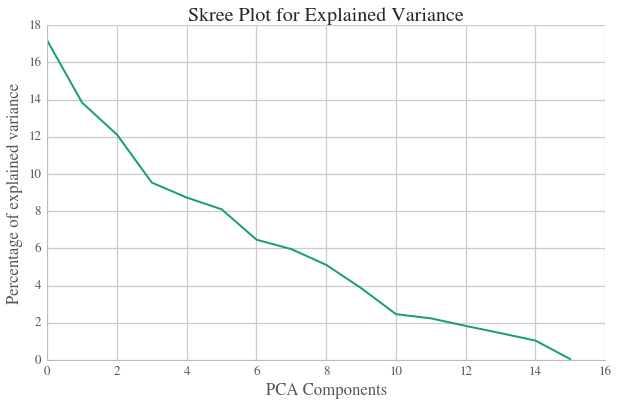

In [221]:
from sklearn.decomposition import PCA

pca = PCA().fit(TrainX_scl, TrainY)
plt.title("Skree Plot for Explained Variance")
plt.ylabel("Percentage of explained variance")
plt.xlabel("PCA Components")
remove_border()
plt.plot(pca.explained_variance_ratio_*100);

We see that the skree has been flattened. No longer is there a bump. We need more components. In fact, the first three do not explain more than 50% - we need to include closer to 10 to get most of the variance explained.

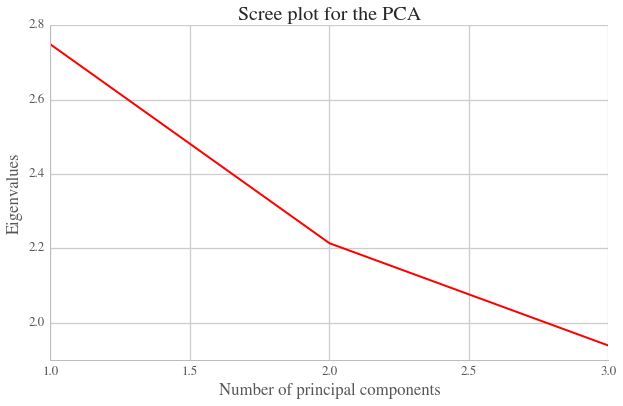

The 1st Principal Component explains  17 % of the variance

The 1st and 2nd Principal Components explain  31 % of the variance

The 1st, 2nd and 3rd Principal Components explain  43 % of the variance


In [222]:
svd = sklearn.decomposition.TruncatedSVD(n_components=3)
TrainX_2d = svd.fit_transform(TrainX_scl)

# we make a scree plot to see how many Principal Components to consider
#fig = plt.figure(figsize=(12, 6))
eig = svd.explained_variance_
# and calculate the variance explained by the PC analysis
var_exp = svd.explained_variance_ratio_.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
remove_border()
plt.show()

print('The 1st Principal Component explains ', var_exp[0].astype(int), '% of the variance' )
print('')
print('The 1st and 2nd Principal Components explain ', var_exp[1].astype(int), '% of the variance' )
print('')
print('The 1st, 2nd and 3rd Principal Components explain ', var_exp[2].astype(int), '% of the variance' )

The plot of eigenvalues against the first 3 components shows that only 43% of the variance is explained. The shape of the plot is almost linear meanin that the components each explain close to the same amount of variance - i.e. similar effects.

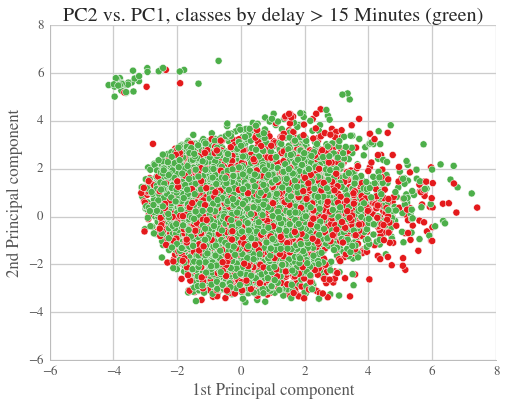

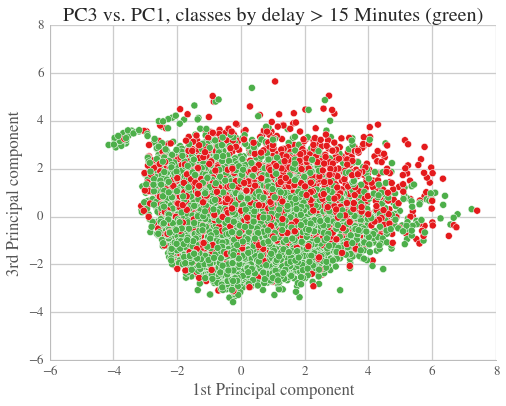

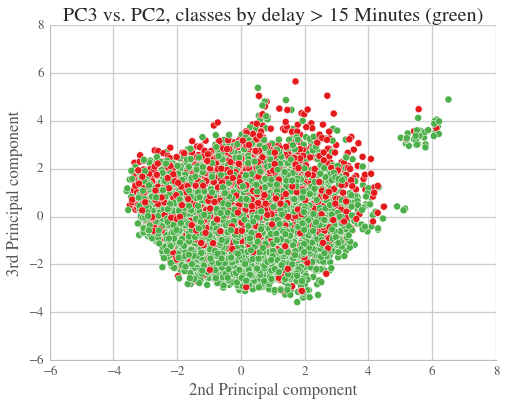

In [223]:
plt.set_cmap(plt.cm.Paired)
cmap=plt.cm.Paired
Pltcolors = cmap([0,1,2])
 
plt.figure(figsize=(8, 6))    
plt.scatter(TrainX_2d[:,0], TrainX_2d[:,1], c=(TrainY >= delay_threshold), s = 50, cmap=cmap_set1)
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.title("PC2 vs. PC1, classes by delay > 15 Minutes (green)")
remove_border()
plt.figure(figsize=(8, 6))    
plt.scatter(TrainX_2d[:,0], TrainX_2d[:,2], c=(TrainY >= delay_threshold), s = 50, cmap=cmap_set1)
plt.ylabel('3rd Principal component' )
plt.xlabel('1st Principal component' )
plt.title("PC3 vs. PC1, classes by delay > 15 Minutes (green)")
remove_border()
plt.figure(figsize=(8, 6))    
plt.scatter(TrainX_2d[:,1], TrainX_2d[:,2], c=(TrainY >= delay_threshold), s = 50, cmap=cmap_set1)
plt.ylabel('3rd Principal component' )
plt.xlabel('2nd Principal component' )
plt.title("PC3 vs. PC2, classes by delay > 15 Minutes (green)")
remove_border()

Interestingly, the third principal component seems to separate the classes from top to bottom quite well, with the red (non delayed) dots having more positive coefficients, and the green (delayed) dots with negative coefficients. The separation in the plots is better than before. The separated cluster in the top right is driving some of the variability - likely these are the features for distance and elapsed time that are most correlated with PC2 and PC3. The dots in the clump have the highest PC2 and PC3 coefficients.

We do linear regression again to see how the model predicts delay times.

In [224]:
X = sm.add_constant(pd.DataFrame(TrainX_scl, columns=[Xcols]))

Y = pd.DataFrame(TrainY, columns=['DepDelay'])
Y_new = pd.DataFrame(TestY, columns=['DepDelay'])
Y = Y.reset_index(drop=True)
print(Y.shape)
print(X.shape)
res_full = sm.OLS(Y,X).fit()
print(res_full.summary())

X_new = sm.add_constant(pd.DataFrame(TestX_scl, columns=[Xcols]))

np.mean((res_full.predict(X_new)-Y_new.values)**2)

(10000, 1)
(10000, 17)
                            OLS Regression Results                            
Dep. Variable:               DepDelay   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     94.42
Date:                Sun, 25 Sep 2016   Prob (F-statistic):          3.45e-290
Time:                        20:13:00   Log-Likelihood:                -50973.
No. Observations:               10000   AIC:                         1.020e+05
Df Residuals:                    9983   BIC:                         1.021e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             17.

2041.6155673271364

We have doubled the number of explanatory variables
in the model. The adjusted R2 shows a marked improvement, rising to almost 12%. On the other hand, the MSE of the prediction on the test set rises to 1827. The model has several coefficients that are not significantly different from zero - notably Carrier, Destination and Departure Airport Temperature.

In [225]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X.values, Y.values)

print('Estimated intercept coefficient:', lm.intercept_)
print('Adjusted R^2 of the regression:',  lm.score(X.values, Y.values))
pd.DataFrame(list(zip(['Int.']+Xcols, lm.coef_[0].T.tolist())), columns = ['Features', 'Estimated Coefficients'])[1:]

Estimated intercept coefficient: [ 17.8255]
Adjusted R^2 of the regression: 0.131441630711


,Features,Estimated Coefficients
1,Month,-3.725121
2,DayOfWeek,-1.760446
3,DepHr,7.202858
4,ArrHr,4.643626
5,UniqueCarrier,0.146375
6,Dest,-1.013071
7,CRSElapsedTime,16.022699
8,Distance,-15.292722
9,Origin_Demand,-7.189711
10,MC_DEP,1.479468


We see also that there is a negative correleation between demand at the origin and destination airports and delay. When the demand is higher, delay is lower. This is perhaps counterintuitive. 

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<function matplotlib.pyplot.show>

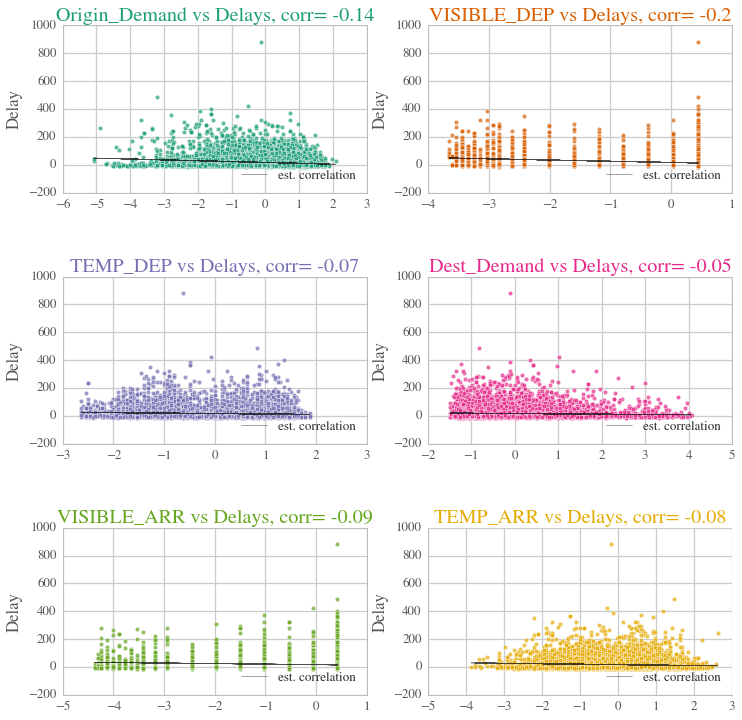

In [226]:
# based on some code from the lectures
Xcols_alt = ['Origin_Demand', 'VISIBLE_DEP', 'TEMP_DEP', 'Dest_Demand', 'VISIBLE_ARR', 'TEMP_ARR']
fig, ax = plt.subplots(3, 2, figsize=(12,12))
for i, k, l in zip(np.arange(len(Xcols_alt)), Xcols_alt,  Xcols_alt):
    correl = round(np.corrcoef(X[k], Y.values[:,0])[0][1],2)
    axX = np.floor(i/2)
    axY = (i % 2 != 0) * 1
    corline = np.polyfit(X[k], Y.values[:,0],1)
    corr_line = np.poly1d(corline)
    ax[axX, axY].scatter(X[k], Y.values[:,0] , alpha = 0.7, c = dark2_colors[i])
    ax[axX, axY].plot(X[k], corr_line(X[k]), '-', alpha = 0.7, c = 'black', linewidth=.5 , label='est. correlation')
    remove_border()
    ax[axX, axY].set_title(l + ' vs Delays, corr= '+ str(correl), color = dark2_colors[i])
    ax[axX, axY].legend(frameon=False, loc='lower right')
    ax[axX, axY].set_ylabel('Delay')
i += 1
plt.show

With the scatterlots of the new variables, we see that delay is correlated negatively. One explanation is that more demand destination airport are those for which flights are prioritized.

Also Visibility is negatively correlated - which is intuitive, since as visibility worsens, more flights are delayed. As expected, temperature at both the departure and arrival airports is negatively correlated with departure delays. A parallel coordinate plot shows more relationships with attributes.

C:\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Confusion matrix
      0     1
0  4736  2455
1   982  1827

precision = 0.43, recall = 0.65, F1 = 0.52, accuracy = 0.66

          0         1
0  0.658601  0.873977
1  0.136560  0.650409


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


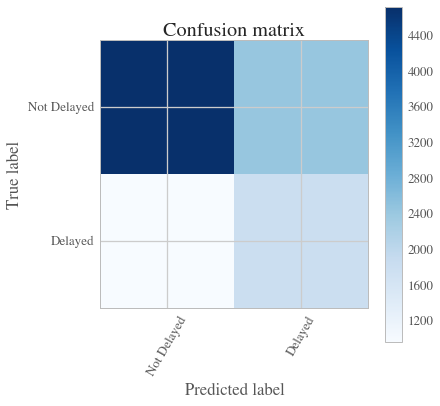

In [227]:
# logistic regression classification model
clf_lr = sklearn.linear_model.LogisticRegression(penalty='l2', class_weight='auto')
logistic_fit=clf_lr.fit(TrainX, np.where(TrainY >= delay_threshold,1,0))

pred = clf_lr.predict(TestX)
# print results
cm_lr = confusion_matrix(np.where(TestY >= delay_threshold,1,0), pred)
print("Confusion matrix")
print(pd.DataFrame(cm_lr))
report_lr = precision_recall_fscore_support(list(np.where(TestY >= delay_threshold,1,0)), list(pred), average='micro')
print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_lr[0], report_lr[1], report_lr[2], accuracy_score(list(np.where(TestY >= delay_threshold,1,0)), list(pred))))
print(pd.DataFrame(cm_lr.astype(np.float64) / cm_lr.sum(axis=1)))
    
show_confusion_matrix(cm_lr)


The accuracy has improved for the LR classification, going from 60% to 66%. The F1 score is 52%. IT appears that the additional features help to obtain better prediction performance.

Now lets look at Random Forest classification.

Confusion matrix
      0     1
0  6625   566
1  1751  1058

precision = 0.65, recall = 0.38, F1 = 0.48, accuracy = 0.77

          0         1
0  0.921291  0.201495
1  0.243499  0.376646


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


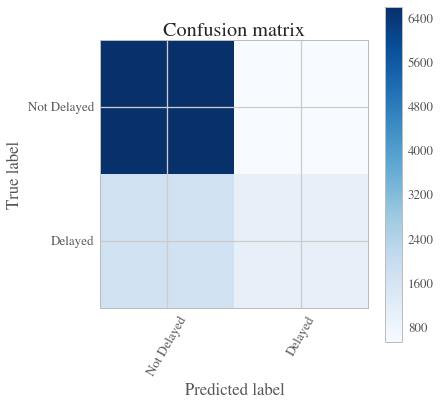

In [228]:
# Create Random Forest classifier with 50 trees
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf_rf.fit(TrainX, np.where(TrainY >= delay_threshold,1,0))

# Evaluate on test set
pred = clf_rf.predict(TestX)
# print results
cm_rf = confusion_matrix(np.where(TestY >= delay_threshold,1,0), pred)
print("Confusion matrix")
print(pd.DataFrame(cm_rf))
report_rf = precision_recall_fscore_support(list(np.where(TestY >= delay_threshold,1,0)), list(pred), average='micro')
print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], accuracy_score(list(np.where(TestY >= delay_threshold,1,0)), list(pred))))
print(pd.DataFrame(cm_rf.astype(np.float64) / cm_rf.sum(axis=1)))
    
show_confusion_matrix(cm_rf)

Accuracy now has improved to 77%, which is a good gain. Precision has also improved to 66% from 53% before and the F1 has also jumped to 47%. The new model seems to perform better. 

Let's look at the importance ranking of the features. 

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


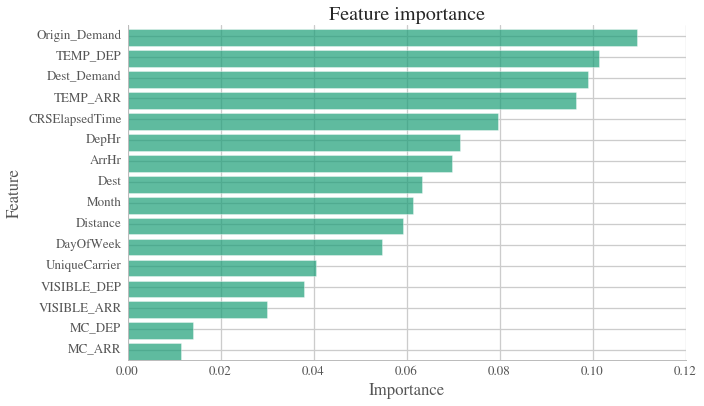

In [229]:
importances = pd.Series(clf_rf.feature_importances_, index=Xcols)
importances.sort()

plt.barh(np.arange(len(importances)), importances, alpha=0.7)
plt.yticks(np.arange(.5,len(importances),1), importances.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance')
remove_border()
plt.show()

The most important features are the Demand and Temperature attributes at the Departure and Arrival airports, followed by the duration and distance. Departure airport attributes are more important generally than the arrival airport ones - something that should reverse in the analysis of arrival delays. Visibility and MC are low in imporance, as is Carrier.

Let's look at cross-validation scores, using 10-fold CV and 50 trees.

In [230]:
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
RF_scores = cross_validation.cross_val_score(clf_rf, TrainX, np.where(TrainY >= delay_threshold,1,0), cv=10, scoring='accuracy')
print(RF_scores.min(), RF_scores.mean(), RF_scores.max())

0.733266733267 0.752597952698 0.777222777223


The model seems robust, and the previous score of 77% is among the highest. Next, we use SVM classification.

In [231]:
from sklearn.svm import SVC
svc =  SVC(kernel='rbf', C=100, gamma=0.001).fit(TrainX_scl, np.where(TrainY >= delay_threshold,1,0))
SVC_scores = cross_val_score(svc, TrainX_scl, np.where(TrainY >= delay_threshold,1,0), cv=10, scoring='accuracy', n_jobs=-1) 
print(SVC_scores.min(), SVC_scores.mean(), SVC_scores.max())

C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Anaconda3\lib\site-packages\skl

0.724 0.732699141099 0.741741741742


The scores from SVM are lower. This could be from the choice of tuning parameters, but it does not seem likely that more tuning would bring us above 77%. We concentrated on improving accuracy with dummy encoding for the categorical variables.

In [233]:
# Use SciKitLearn OneHotEncoder to see if the model is improved
from sklearn.preprocessing import OneHotEncoder
categ = [Xcols.index(x) for x in ('Month', 'DayOfWeek', 'UniqueCarrier', 'Dest', 'VISIBLE_DEP', 'VISIBLE_ARR')]
encoder = OneHotEncoder(categorical_features = categ)
TrainXenc = encoder.fit_transform(TrainX).toarray()
TestXenc = encoder.transform(TestX).toarray()

ValueError: unknown categorical feature present [14 13] during transform.

In [234]:
# Create Random Forest classifier with 35 trees
clf_rf = RandomForestClassifier(n_estimators=35, n_jobs=-1)
clf_rf.fit(TrainXenc, np.where(TrainY >= delay_threshold,1,0))

# Evaluate on test set
pred = clf_rf.predict(TestXenc)
# print results
cm_rf = confusion_matrix(np.where(TestY >= delay_threshold,1,0), pred)
print("Confusion matrix")
print(pd.DataFrame(cm_rf))
report_rf = precision_recall_fscore_support(list(np.where(TestY >= delay_threshold,1,0)), list(pred), average='micro')
print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], accuracy_score(list(np.where(TestY >= delay_threshold,1,0)), list(pred))))
print(pd.DataFrame(cm_rf.astype(np.float64) / cm_rf.sum(axis=1)))
    
show_confusion_matrix(cm_rf)

ValueError: Number of features of the model must  match the input. Model n_features is 129 and  input n_features is 182 

We increase precision marginally, but accuracy stays the same. It does not seem to be that important to dummy encode.

Finally, as a last step,. we go back to the full dataset and perform classification using the RF with 50 trees and the new weather variables. We need to spilt into train and test datasets randomly and then scale them (actually we don't really need to scale for RF, but we do it anyway.

In [235]:
# we go back to the full dataset, to evaluate the performance 
scaler = StandardScaler()
TrainX, TestX, TrainY, TestY = train_test_split(
    X_values, Y_values, test_size=0.50, random_state=0)
TrainX_scl = scaler.fit_transform(TrainX)
TestX_scl = scaler.transform(TestX)

In [236]:
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
RF_scores = cross_validation.cross_val_score(clf_rf, TrainX, np.where(TrainY >= delay_threshold,1,0), cv=10, scoring='accuracy')
print(RF_scores.min(), RF_scores.mean(), RF_scores.max())

0.765701998029 0.768920636291 0.771525848938


The cross validation scores look as good as with the random sampled subset, with close to 77% accuracy. Next we use the training set and then the test data to see how well the model performs.

Confusion matrix
       0      1
0  72589   6991
1  18728  13304


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)



precision = 0.66, recall = 0.42, F1 = 0.51, accuracy = 0.77

          0         1
0  0.912151  0.218250
1  0.235336  0.415335


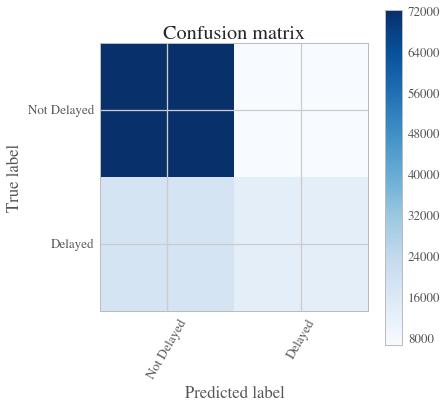

In [237]:
# Create Random Forest classifier with 50 trees
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf_rf.fit(TrainX, np.where(TrainY >= delay_threshold,1,0))

# Evaluate on test set
pred = clf_rf.predict(TestX)
# print results
cm_rf = confusion_matrix(np.where(TestY >= delay_threshold,1,0), pred)
print("Confusion matrix")
print(pd.DataFrame(cm_rf))
report_rf = precision_recall_fscore_support(list(np.where(TestY >= delay_threshold,1,0)), list(pred), average='micro')
print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], accuracy_score(list(np.where(TestY >= delay_threshold,1,0)), list(pred))))
print(pd.DataFrame(cm_rf.astype(np.float64) / cm_rf.sum(axis=1)))
    
show_confusion_matrix(cm_rf)

We get precision at 77%, and the F1 score is above 50%. Precision is at 66%. The selected model is good at predicting departure delays of more than 15 minutes. Let's look at the importances ranking. 

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


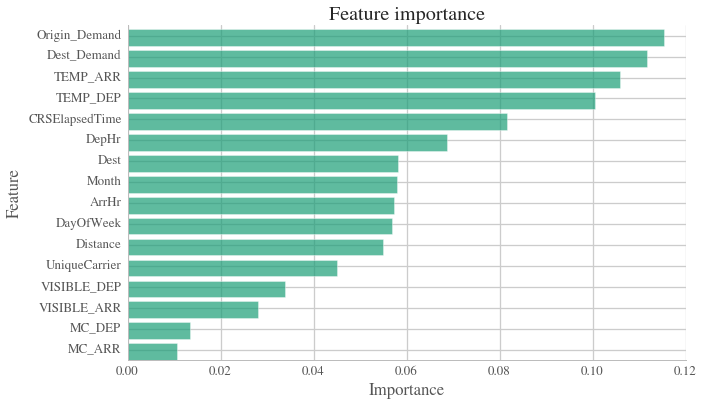

In [238]:
importances = pd.Series(clf_rf.feature_importances_, index=Xcols)
importances.sort()

plt.barh(np.arange(len(importances)), importances, alpha=0.7)
plt.yticks(np.arange(.5,len(importances),1), importances.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance')
remove_border()
plt.show()

On the full dataset, origin and destination demand are the most important features, followed by temperature at the destination and origin. Then duration and departure hour are the most important. Again, the MC and Visibility variables are the least important.

As a last step, we try dummy encoding on the full dataset to see if there is an improvement.

In [239]:
# Use SciKitLearn OneHotEncoder to see if the model is improved
from sklearn.preprocessing import OneHotEncoder
categ = [Xcols.index(x) for x in ('Month', 'DayOfWeek', 'UniqueCarrier', 'Dest', 'VISIBLE_DEP', 'VISIBLE_ARR')]
encoder = OneHotEncoder(categorical_features = categ)
TrainXenc = encoder.fit_transform(TrainX).toarray()
TestXenc = encoder.transform(TestX).toarray()

Confusion matrix
       0      1
0  73418   6162
1  19299  12733

precision = 0.67, recall = 0.40, F1 = 0.50, accuracy = 0.77

          0         1
0  0.922568  0.192370
1  0.242511  0.397509


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


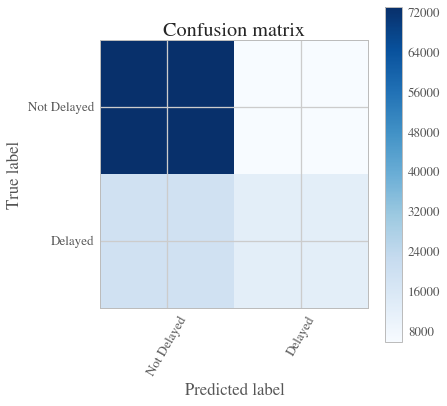

In [240]:
# Create Random Forest classifier with 50 trees
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf_rf.fit(TrainXenc, np.where(TrainY >= delay_threshold,1,0))

# Evaluate on test set
pred = clf_rf.predict(TestXenc)
# print results
cm_rf = confusion_matrix(np.where(TestY >= delay_threshold,1,0), pred)
print("Confusion matrix")
print(pd.DataFrame(cm_rf))
report_rf = precision_recall_fscore_support(list(np.where(TestY >= delay_threshold,1,0)), list(pred), average='micro')
print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], accuracy_score(list(np.where(TestY >= delay_threshold,1,0)), list(pred))))
print(pd.DataFrame(cm_rf.astype(np.float64) / cm_rf.sum(axis=1)))
    
show_confusion_matrix(cm_rf)

Not really. We stick with the original factored variables, since they are easier to interpret. The analysis has shown that we can arrive at good prediction with the combination of flight origin and destination information such as time of day and the month. Adding weather and airport demand information improves the predication. The Random Forest classifier seems to be the best for this flight delay problem. 

# Findings

Objective: 

To predict flight departure delay. Instead of quantifying the amount of delay, we try to categorize if a flight is on-time (with a departure delay less than 15-min) or delayed (with a departure delay more than 15-min).

In the analysis, we used 2008 Chicago O'Hare International (ORD) departure traffic as an example for our flight departure delay analysis.

Several machine learning techniques are used for predicting if a flight has departure delay. We did this in three iterations as stated earlier.

First, we used 1) a regression model to examine the significance of each features and 2) a feature selection approach to examine the impact of feature combinations. These two techniques determined the features to retain in the model. Instead of using the whole set, we first sample only 10,000 records to run through different machine learning models. 

Two machine learning models were used: a random forest classifier and a SVM classifier with cross validation scores using 10 folds.

Also, we applied an approach called One-Hot-Encoder to create a variant of the model for evaluating potential prediction performance as well. Finally, once we determine an appropriate model variant, we use the full ORD data set to examine the model performance.

Our result shows that the Random Forest method yields the best performance compared against the SVM model. The SVM model is very time consuming (computer intensive) but did not necessarily yield better results.

Prediction

At the end, our model correctly predicted 91% of the non-delayed flights.  However, the delayed flights predicted correctly only 41% of the time. A lot of the time, when we predict a flight that is not delayed, it is actually delayed. It could be that additional features related to the causes of flight delay are not yet discovered using our existing data sources. We can only assume that additional data, perhaps be included to improve the model:

1.	Tail Number – indicating the age of the flight
2.	Airport Air Traffic Control Event

Features Importance

The following features were found to be critical in predicting delays
1.	Demand – Traffic volumes at airport
2.	Temperatures
3.	Flight duration
For the interest of time, we only use Chicago (ORD) as an example. In addition to the ideas we proposed in the previous section to improve the accuracy of the model for delayed flights. This model can be extended to other airports easily. In addition, given the amount of data that is available, we can further create sub- models for specific airlines at an airport provided that the airlines have fair share of the operations at an airport.

